# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [2]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat_64/'

# Function
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import pickle

## Load the Evaluation Dataset

In [3]:
f = open(data_path+"meerkat_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

## Extract Batches and Concatenate Them

In [4]:
batch.keys()
n_batch, Nx, Ny = batch['targets'].shape

## Plot Galaxy Images

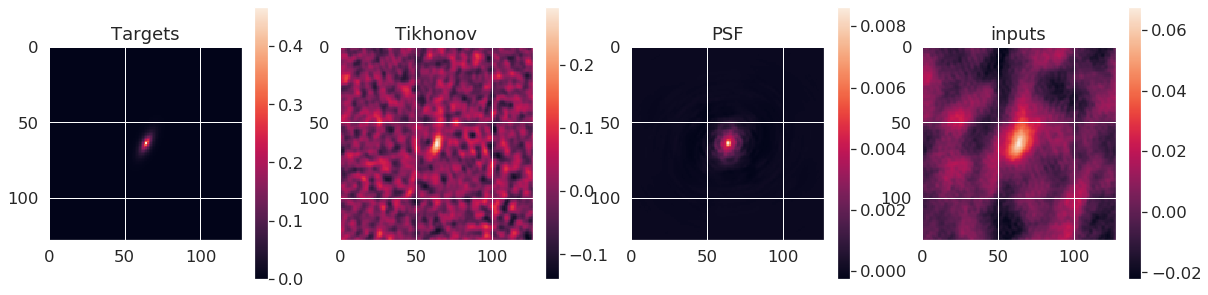

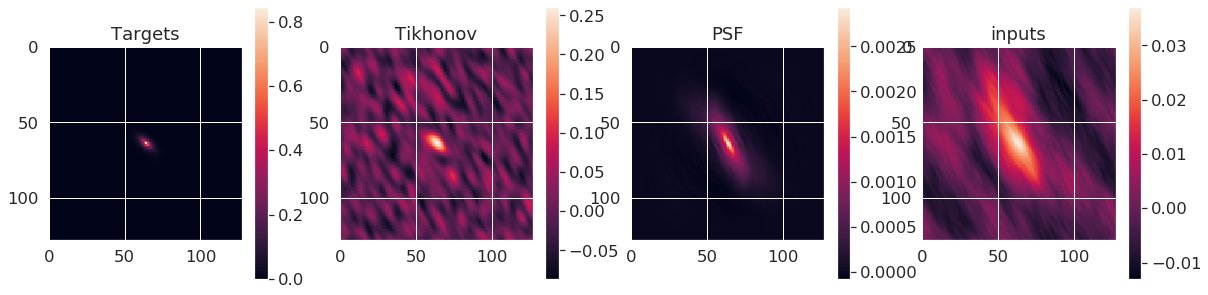

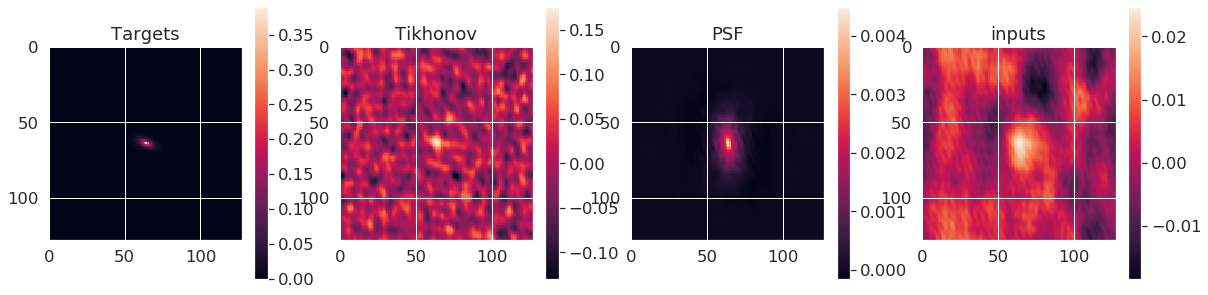

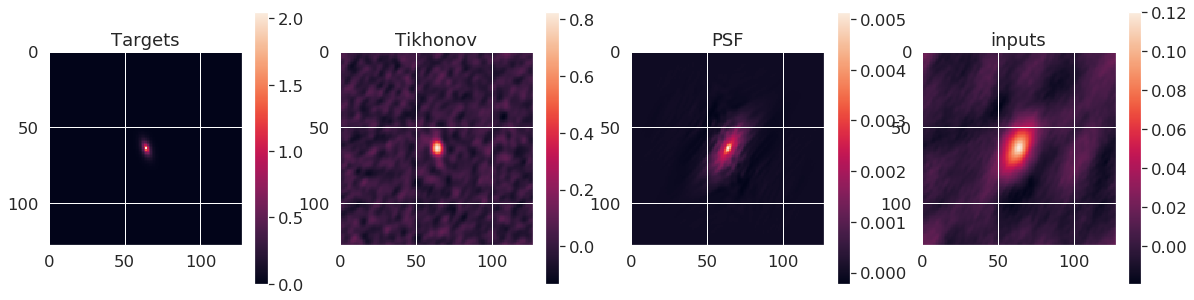

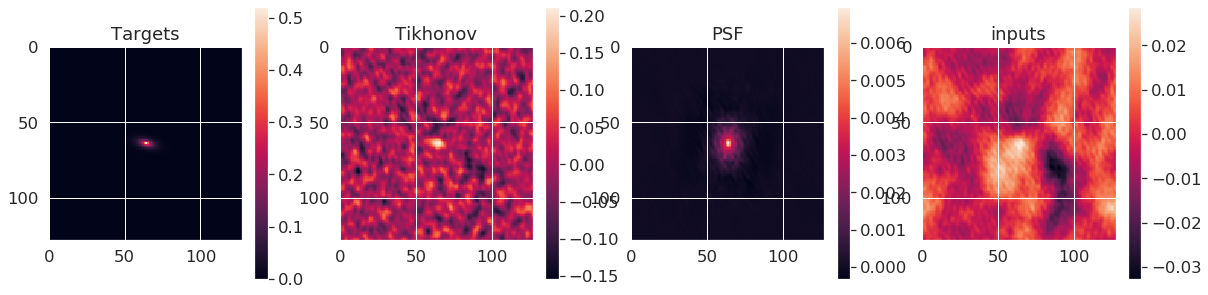

In [5]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(5):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(batch['inputs_tikho'][i])
    plt.title('Tikhonov')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(batch['psf'][i])
    plt.title('PSF')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

## Load and Apply Trained Model on Batch

In [6]:
g = open(data_path+"clean_results.pkl", "rb")
clean = pickle.load(g)
g.close()

clean.keys()

dict_keys(['restored_residual', 'restored', 'restored_isotropic', 'residual', 'skymodel', 'skymodel_list', 'sigma_flags'])

In [7]:
# load Tikhonet results
model_name_g0 = 'tikhonet_None-constraint_scales-4_steps-3125_epochs-10_growth_rate-12_batch_size-32_activationfunction-relu'
model_name_g05 = 'tikhonet_multi-constraint_scales-4_gamma-0.5_shearlet-3_steps-3125_epochs-10_growth_rate-12_batch_size-32_activationfunction-relu'

model_g0 = tf.keras.models.load_model(model_dir+model_name_g0, compile=False)
model_g05 = tf.keras.models.load_model(model_dir+model_name_g05, compile=False)

inputs_model = np.expand_dims(np.array([crop_center(im,64,64) for im in batch['inputs_tikho']]),axis=-1)

res_g0 = model_g0(inputs_model)
res_g05 = model_g05(inputs_model)

res_g0 = np.array([np.pad(im,32,constant_values=0) for im in tf.keras.backend.eval(res_g0)[...,0]])#np.pad(tf.keras.backend.eval(res_g0)[...,0], 32, constant_values=0)
res_g05 = np.array([np.pad(im,32,constant_values=0) for im in tf.keras.backend.eval(res_g05)[...,0]])#np.pad(tf.keras.backend.eval(res_g05)[...,0], 32, constant_values=0)

# load CLEAN
res_cl = clean['restored']
res_cl_iso = clean['restored_isotropic']

# load SCORE
res_s0 = np.load(data_path+'score_radio_g0_1.npy')
res_s1 = np.load(data_path+'score_radio_g0_1.npy')

for i in range(3):
    res_s0 = np.concatenate((res_s0,np.load(data_path+'score_radio_g0_{}.npy'.format(i+2))), axis=0)
    res_s1 = np.concatenate((res_s1,np.load(data_path+'score_radio_g1_{}.npy'.format(i+2))), axis=0)
res_s0 = np.array(res_s0)
res_s1 = np.array(res_s1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Crop images to 64x64

In [8]:
batch['inputs_tikho'] = np.array([crop_center(im,64,64) for im in batch['inputs_tikho']])
batch['inputs'] = np.array([crop_center(im,64,64) for im in batch['inputs']])
batch['targets'] = np.array([crop_center(im,64,64) for im in batch['targets']])
res_g0 = np.array([crop_center(im,64,64) for im in res_g0])
res_g05 = np.array([crop_center(im,64,64) for im in res_g05])
res_cl = np.array([crop_center(im,64,64) for im in res_cl])
res_cl_iso = np.array([crop_center(im,64,64) for im in res_cl_iso])
res_s0 = np.array([crop_center(im,64,64) for im in res_s0])
res_s1 = np.array([crop_center(im,64,64) for im in res_s1])

# flag galaxies where clean did not detect signal
batch['inputs_tikho'] = batch['inputs_tikho'][clean['sigma_flags']]
batch['inputs'] = batch['inputs'][clean['sigma_flags']]
batch['targets'] = batch['targets'][clean['sigma_flags']]
res_g0 = res_g0[clean['sigma_flags']]
res_g05 = res_g05[clean['sigma_flags']]
res_cl = res_cl[clean['sigma_flags']]
res_cl_iso = res_cl_iso[clean['sigma_flags']]
res_s0 = res_s0[clean['sigma_flags']]
res_s1 = res_s1[clean['sigma_flags']]

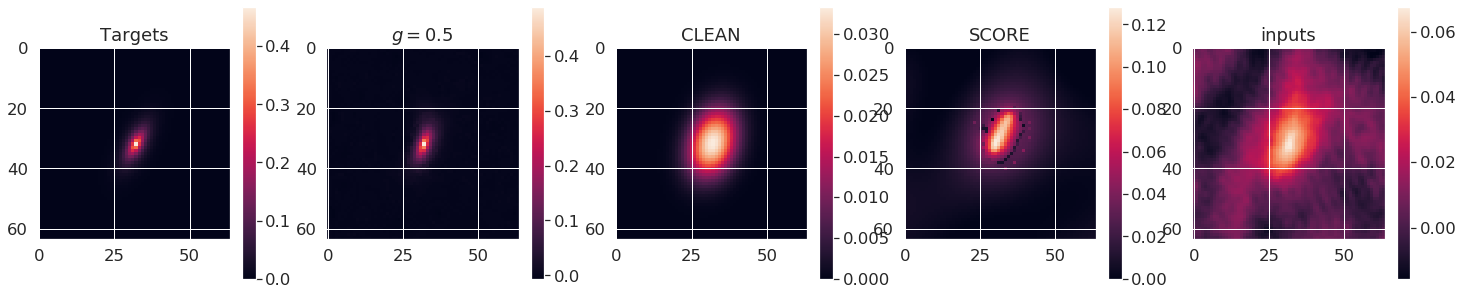

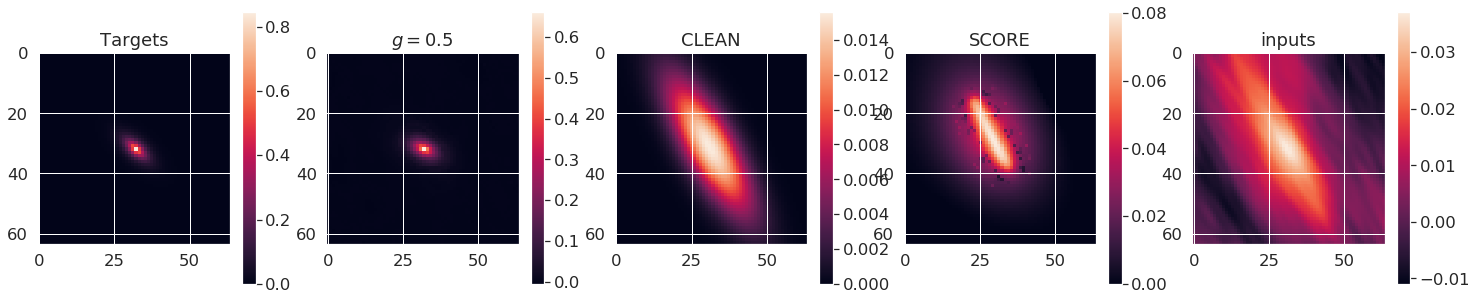

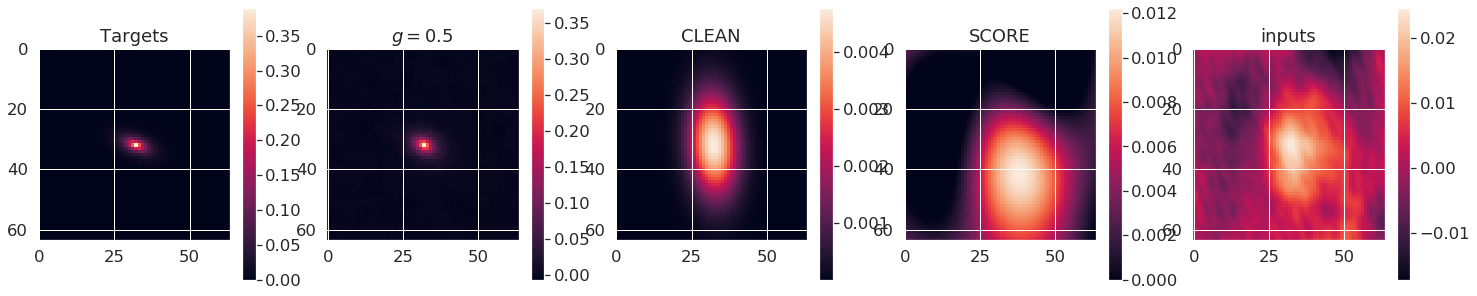

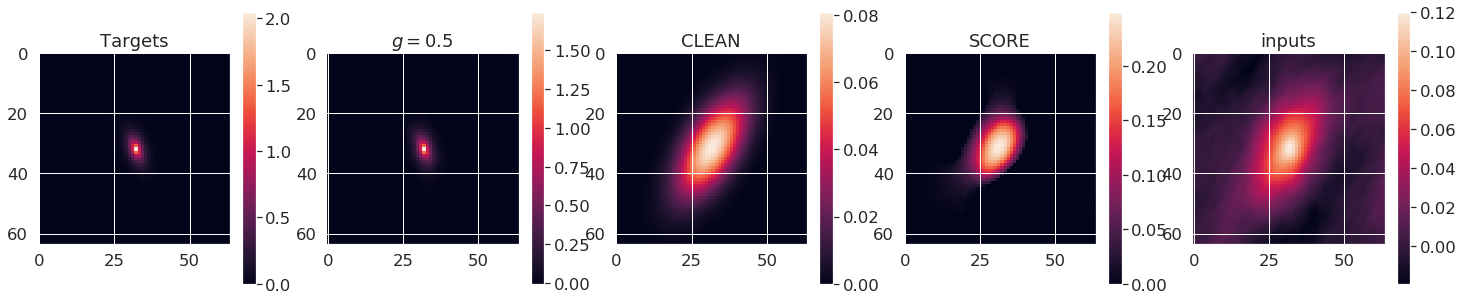

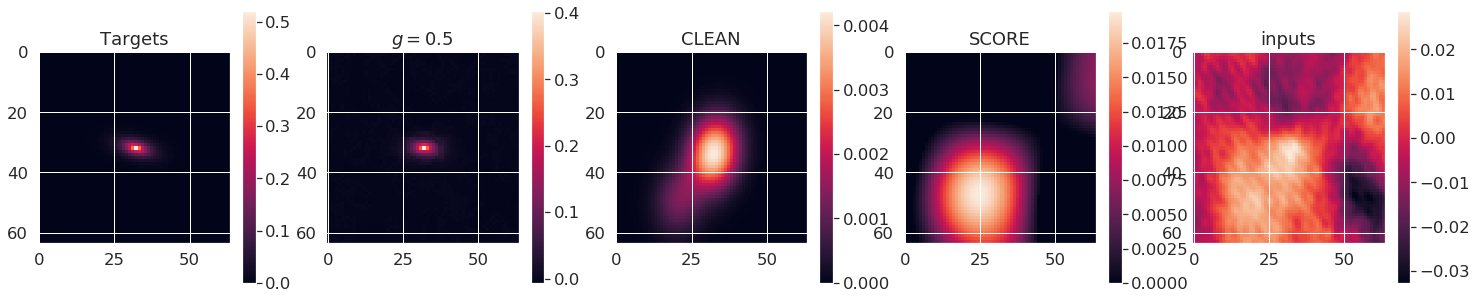

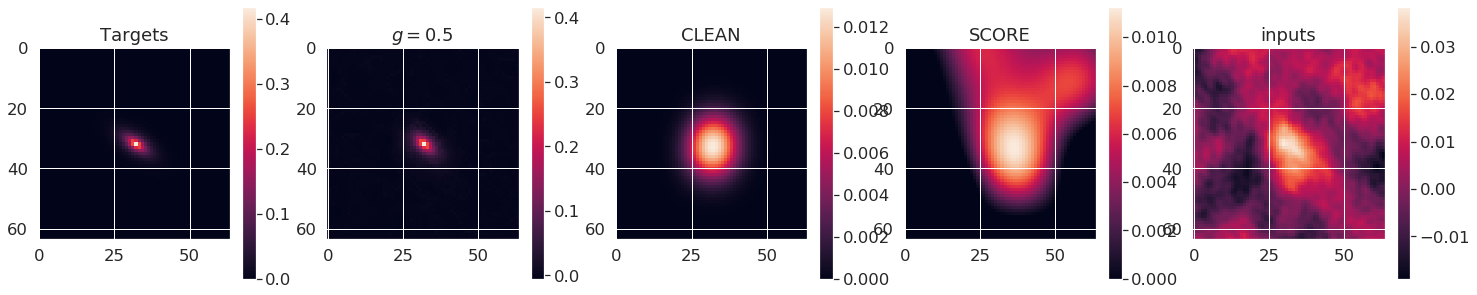

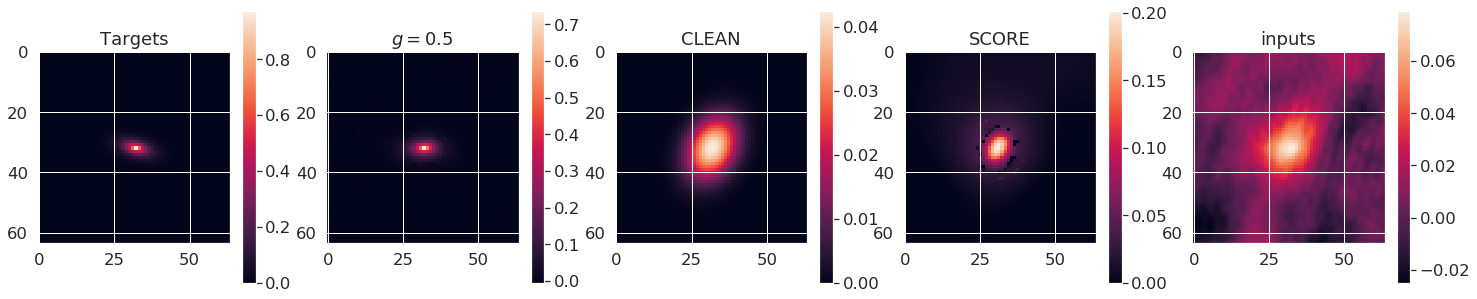

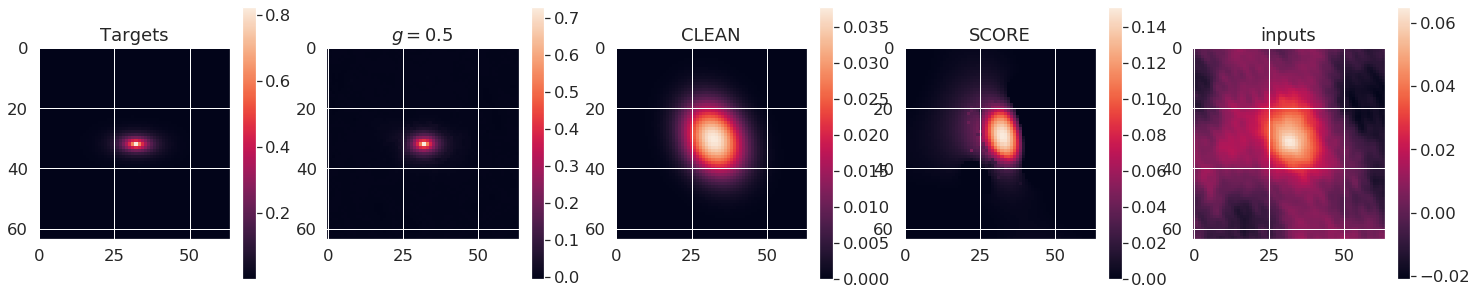

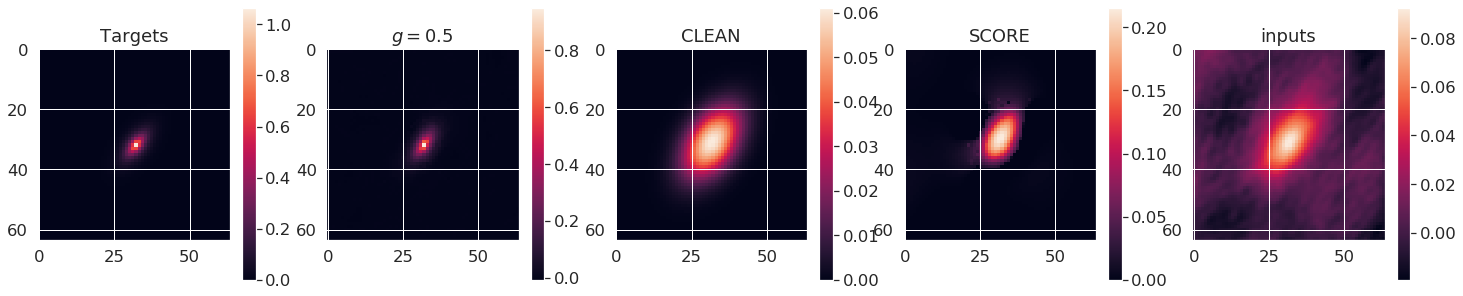

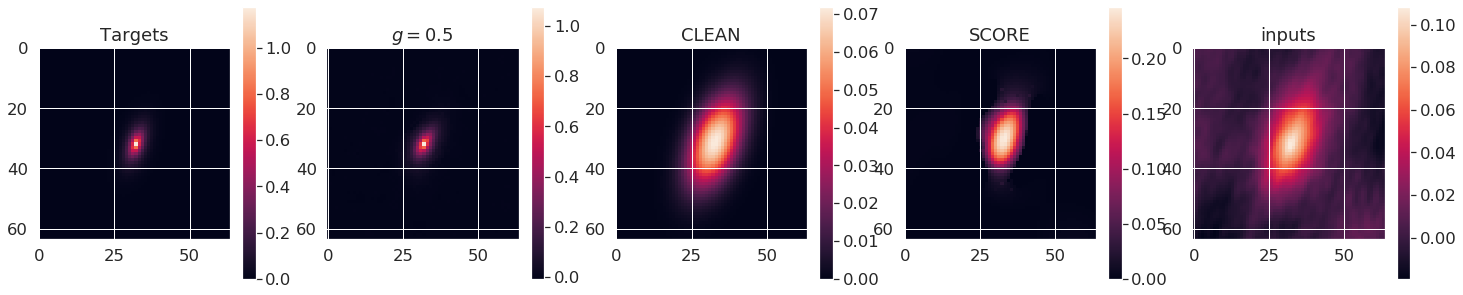

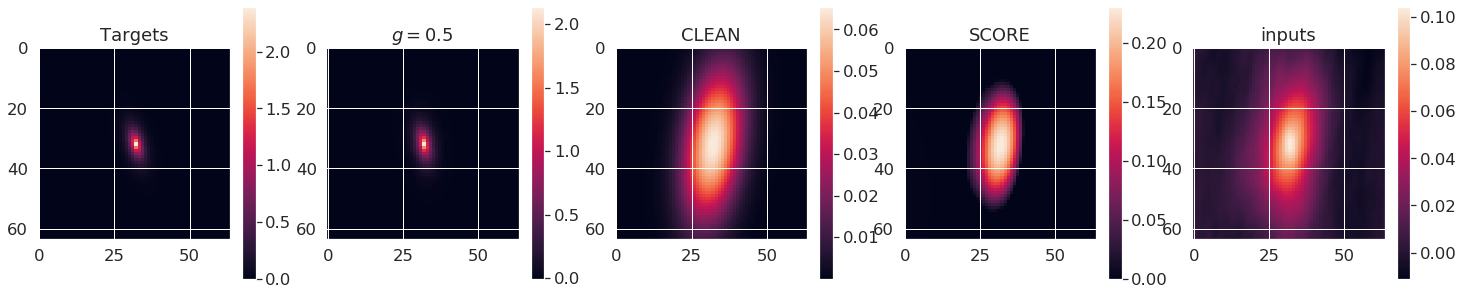

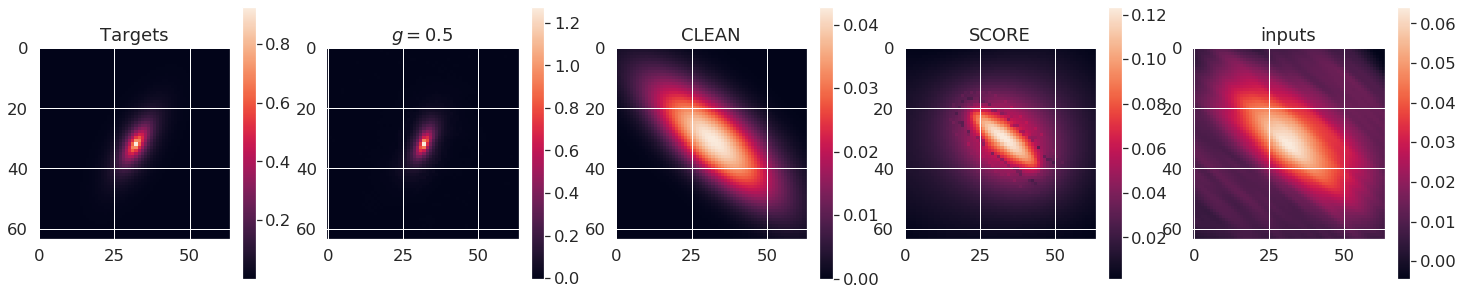

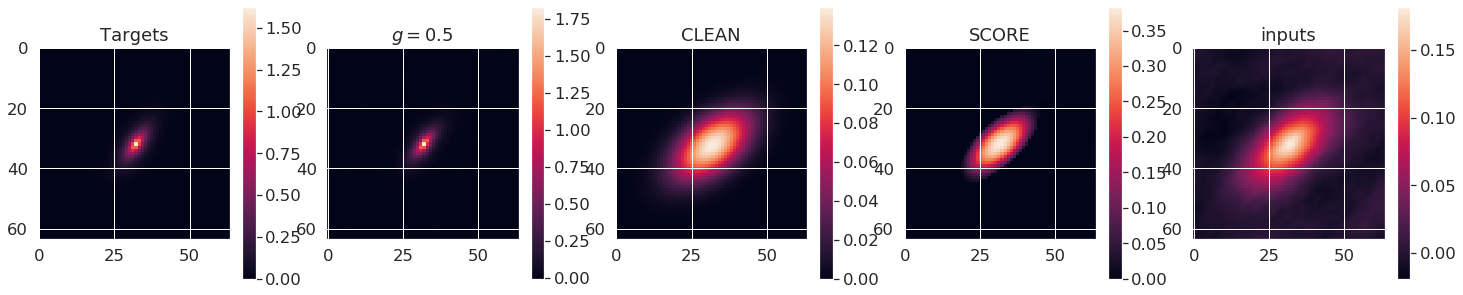

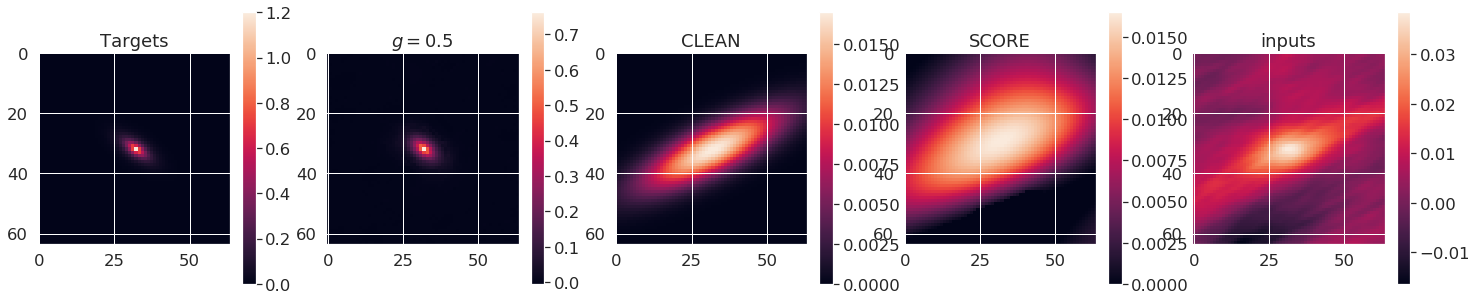

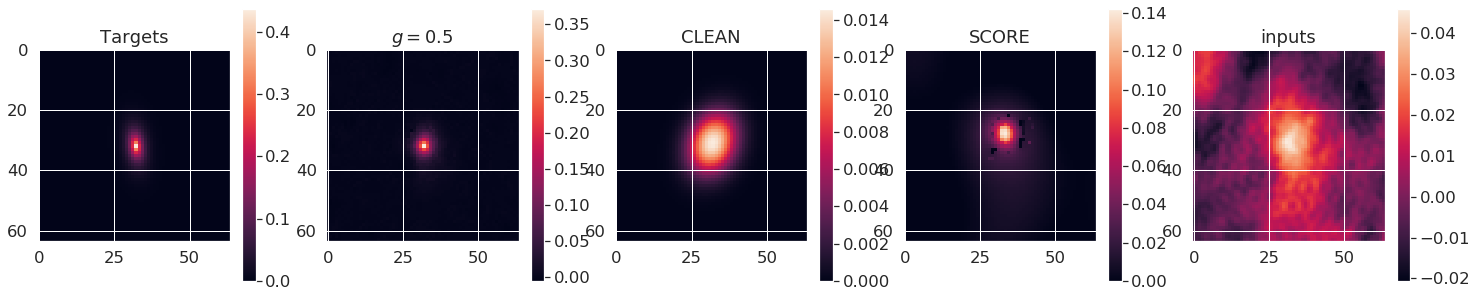

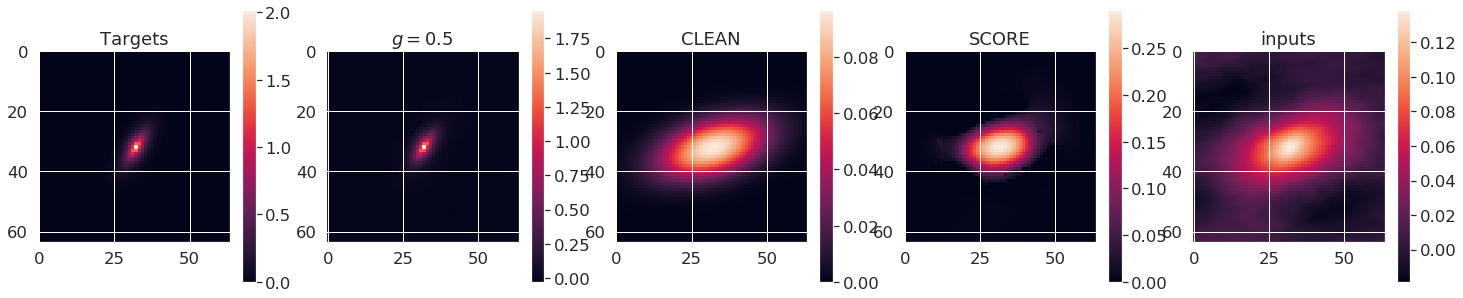

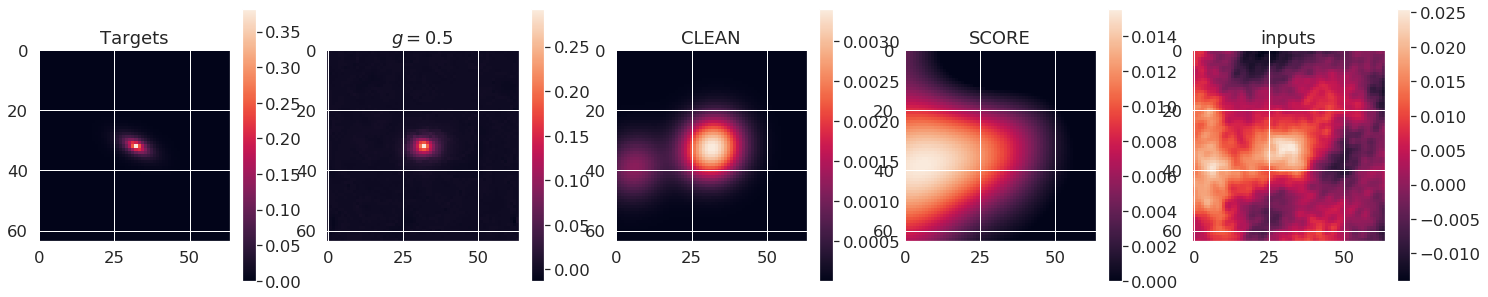

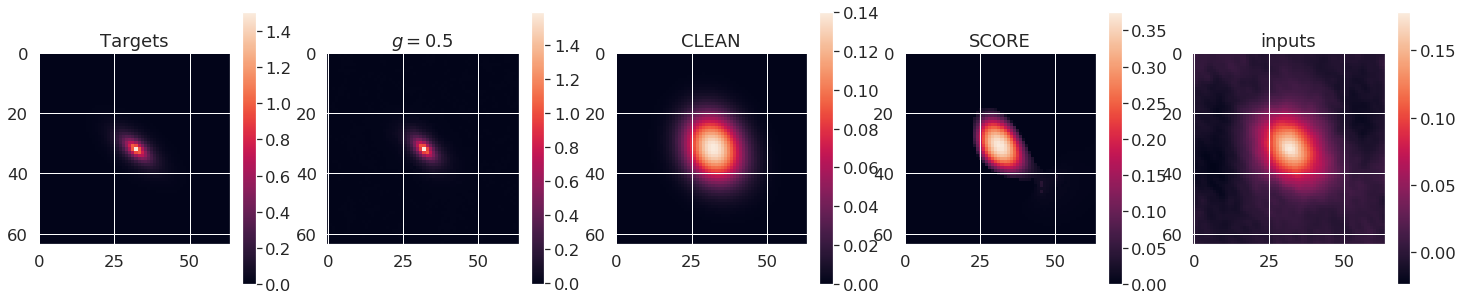

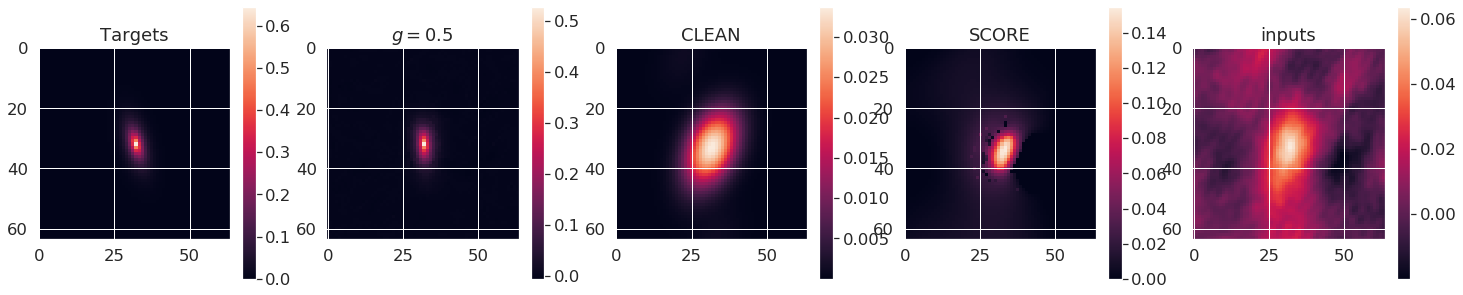

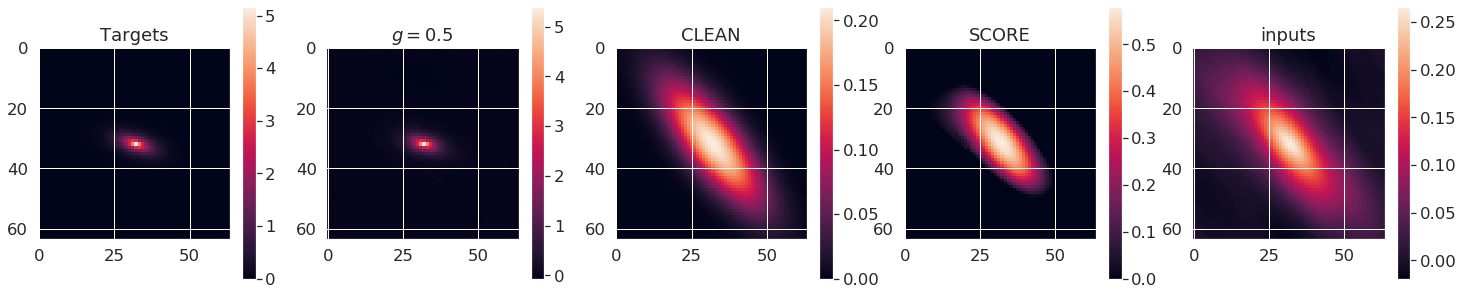

In [9]:
for i in range(20):#n_batch):
    plt.figure(33,figsize=(25,5))
    plt.subplot(151)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(152)
    plt.imshow(res_g05[i])
    plt.title(r'$g=0.5$')
    plt.colorbar()
    plt.subplot(153)
    plt.imshow(res_cl[i])
    plt.title('CLEAN')
    plt.colorbar()
    plt.subplot(154)
    plt.imshow(res_s0[i])
    plt.title('SCORE')
    plt.colorbar()
    plt.subplot(155)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

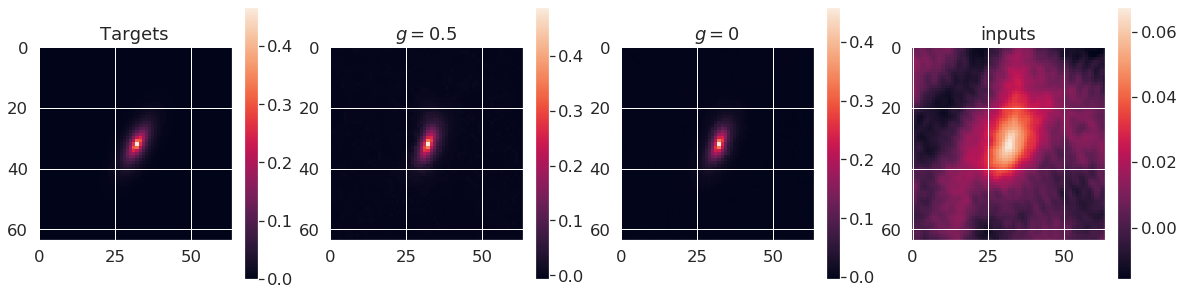

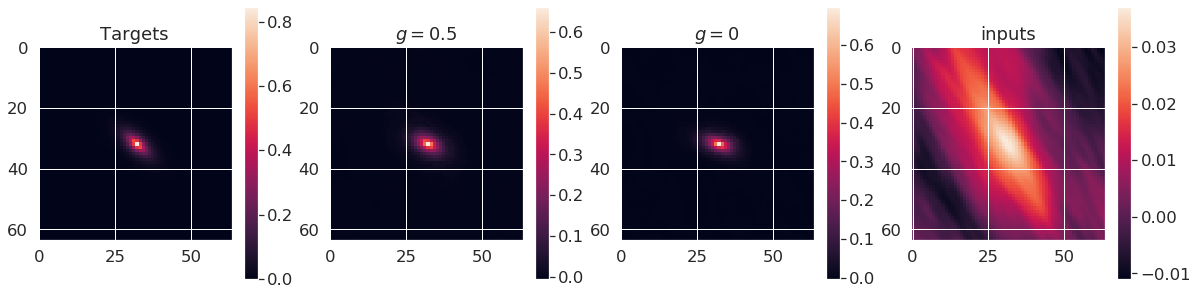

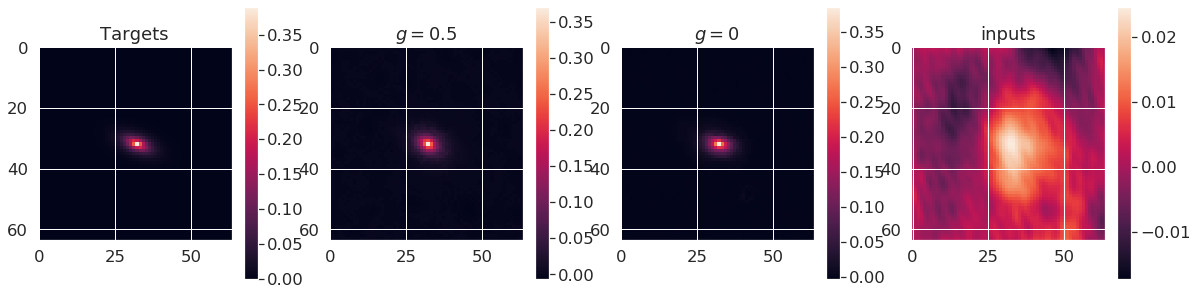

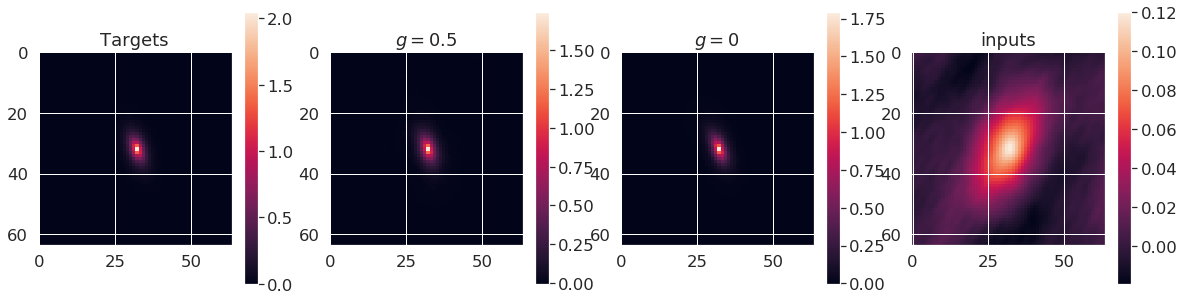

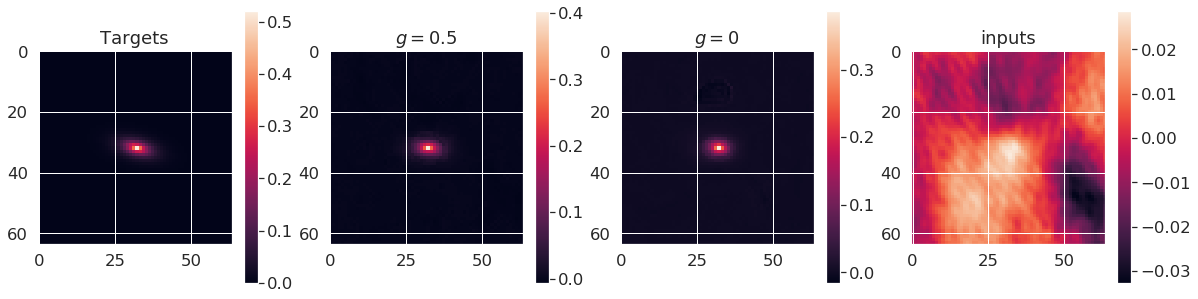

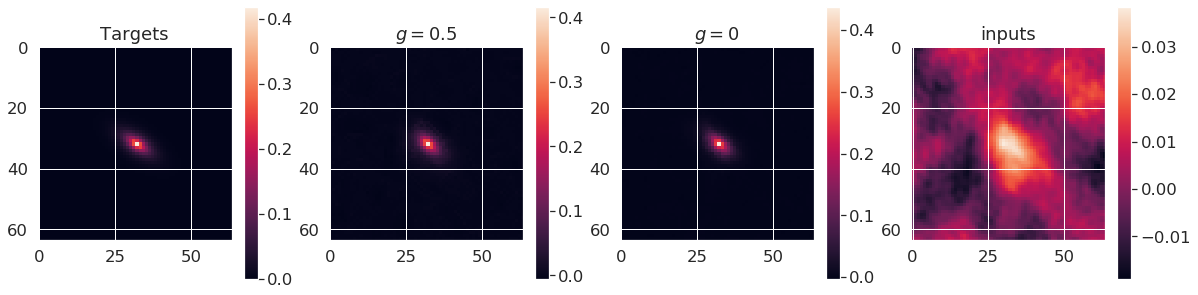

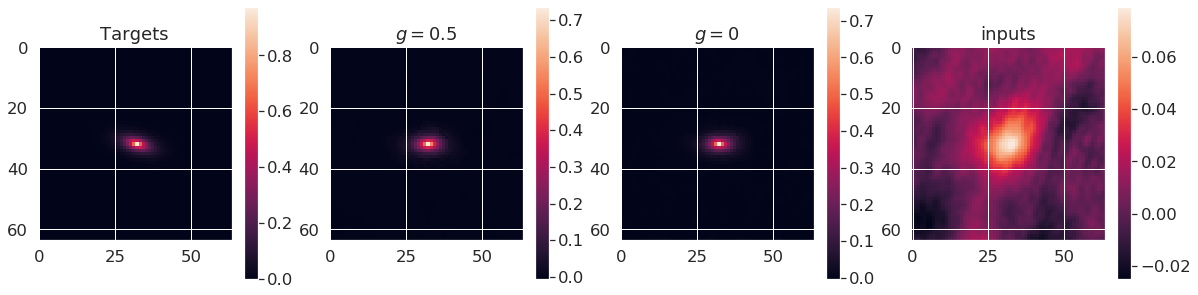

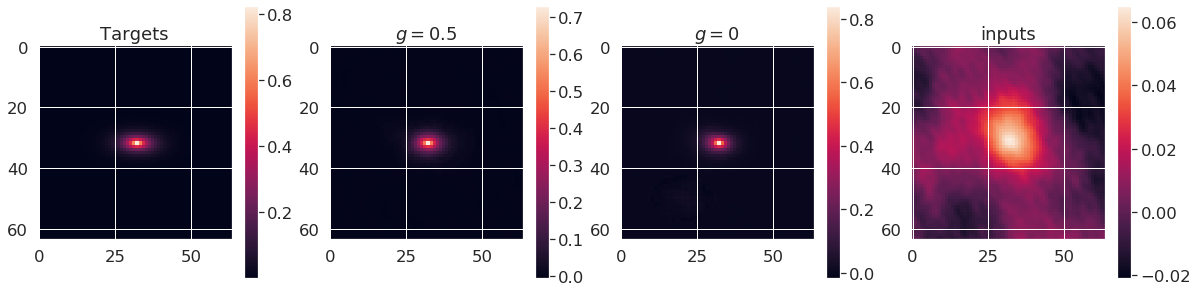

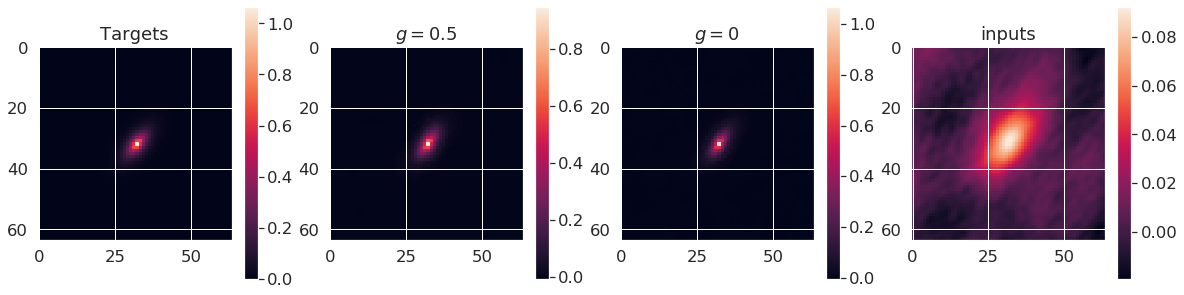

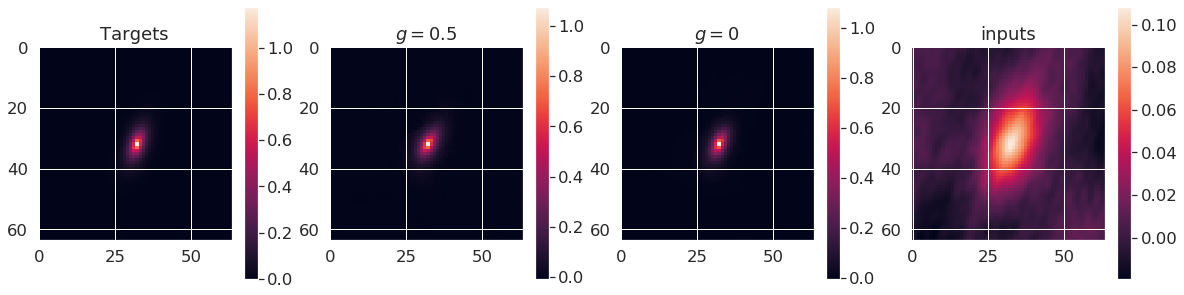

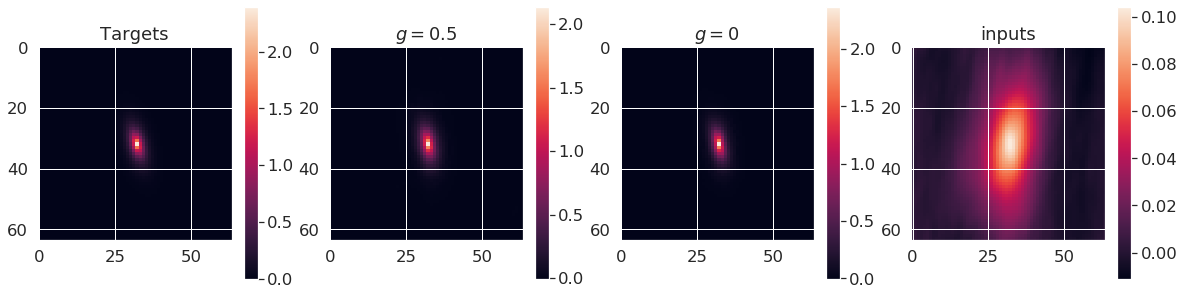

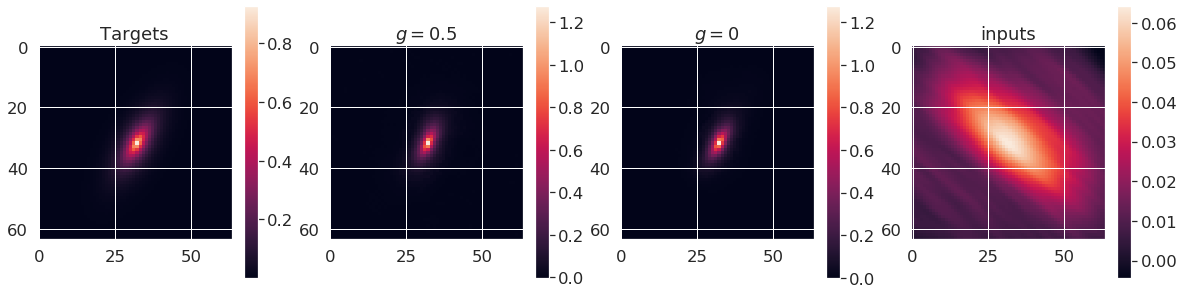

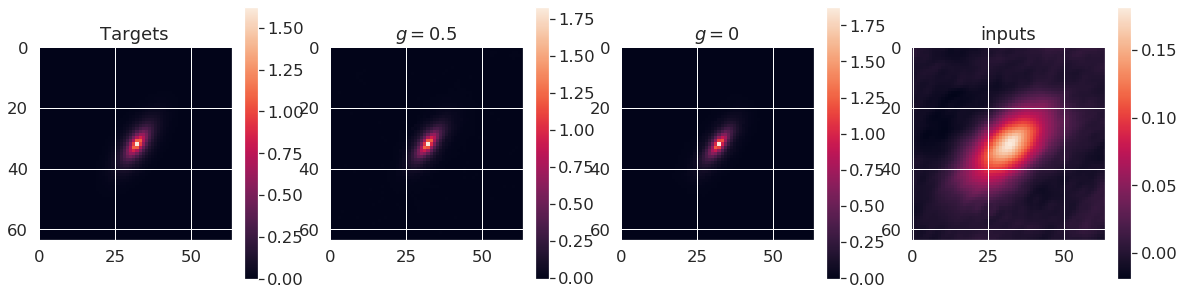

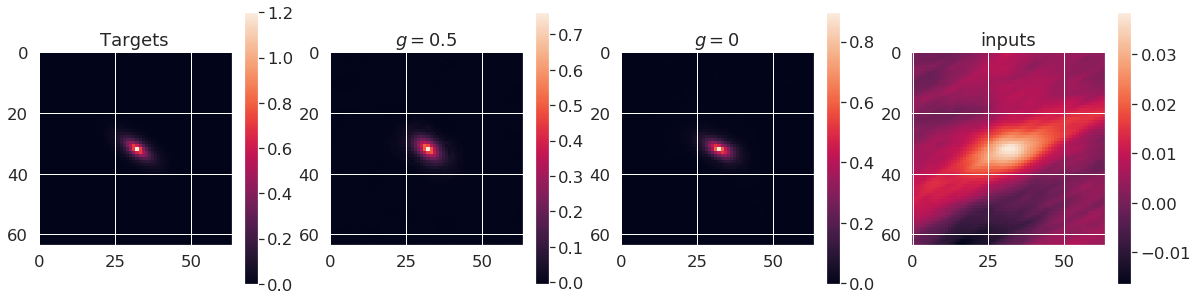

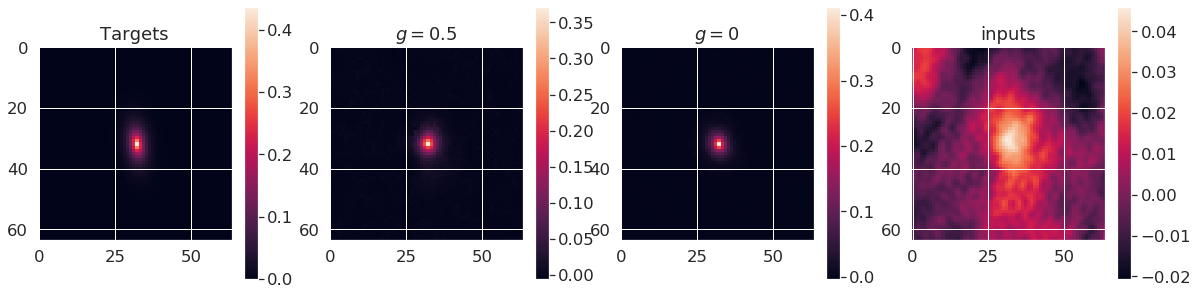

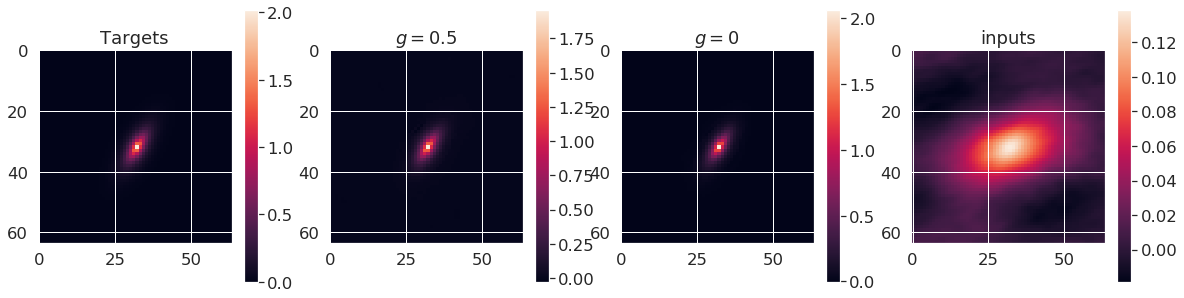

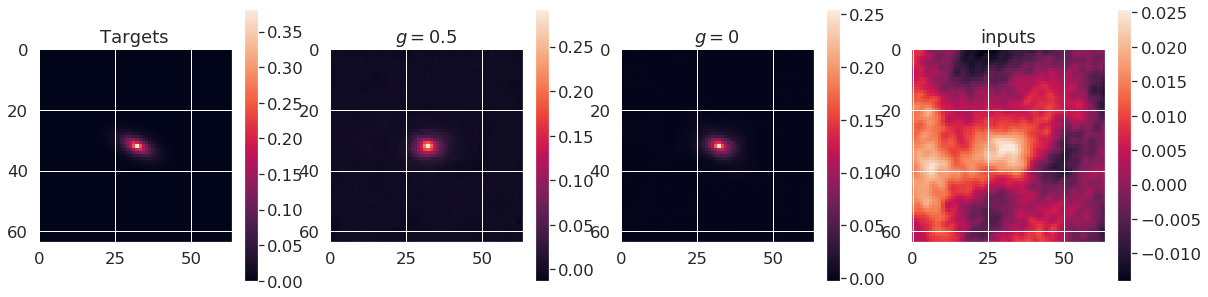

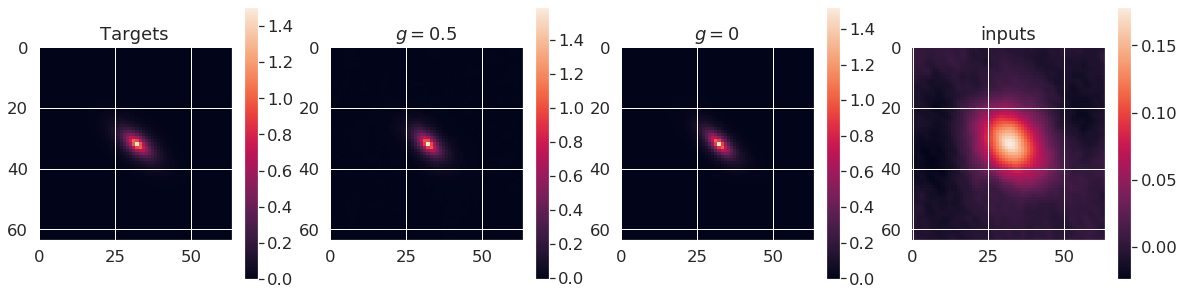

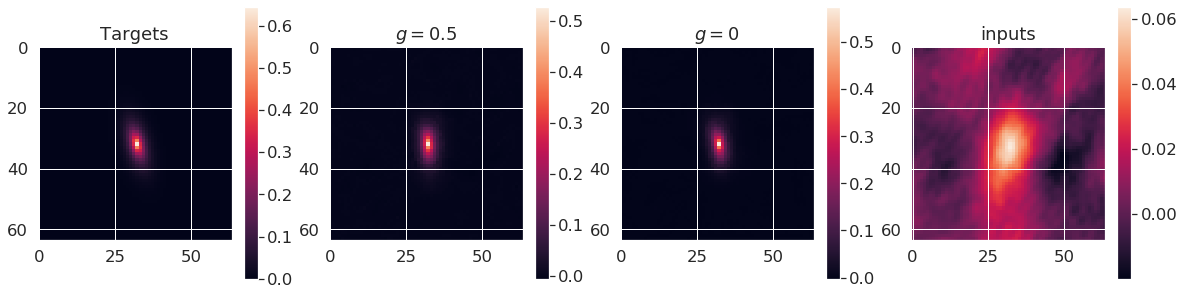

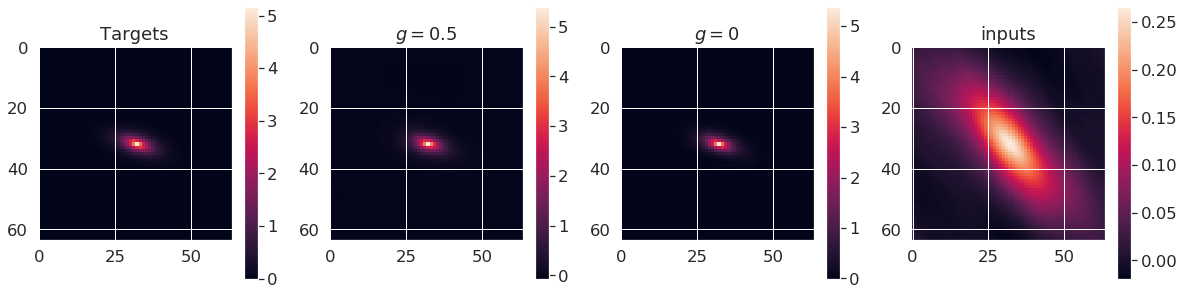

In [10]:
for i in range(20):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(res_g05[i])
    plt.title(r'$g=0.5$')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(res_g0[i])
    plt.title(r'$g=0$')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

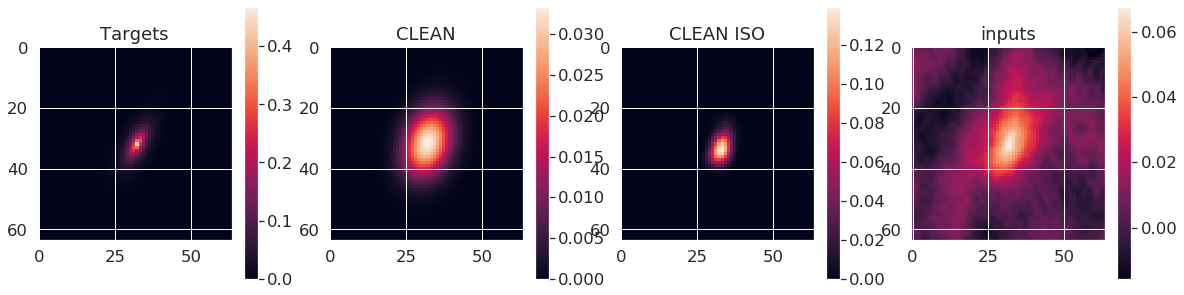

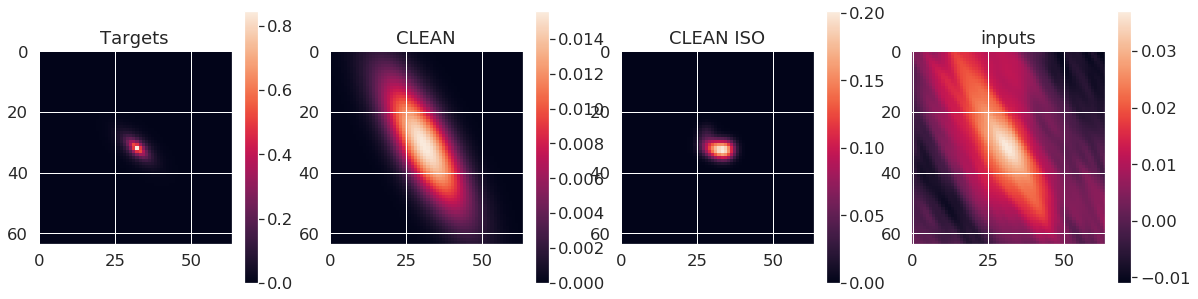

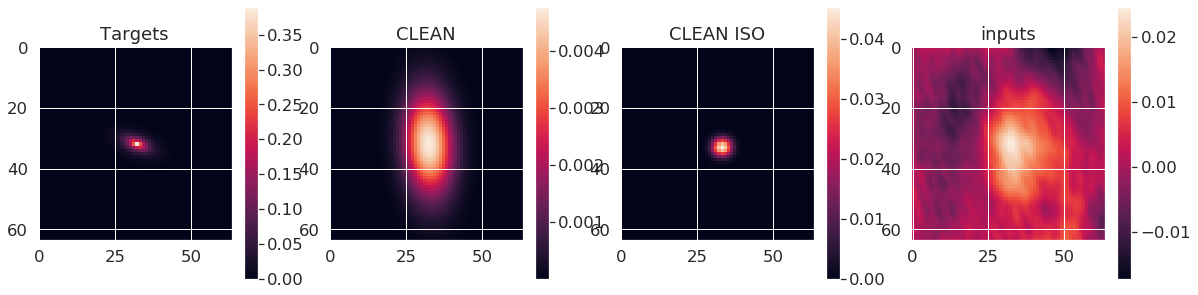

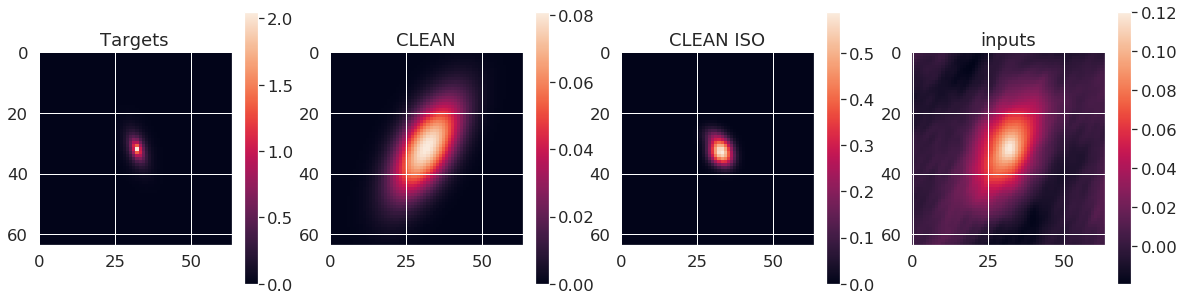

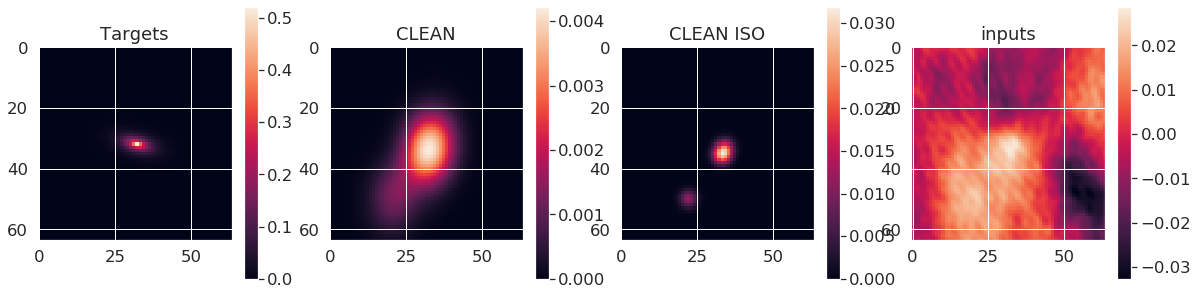

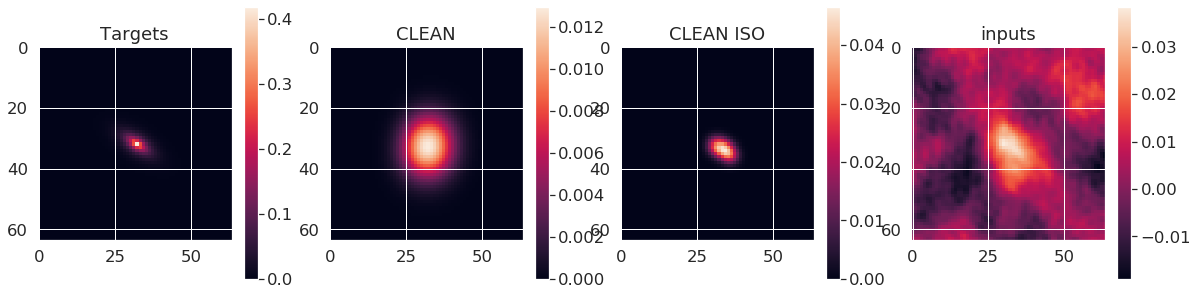

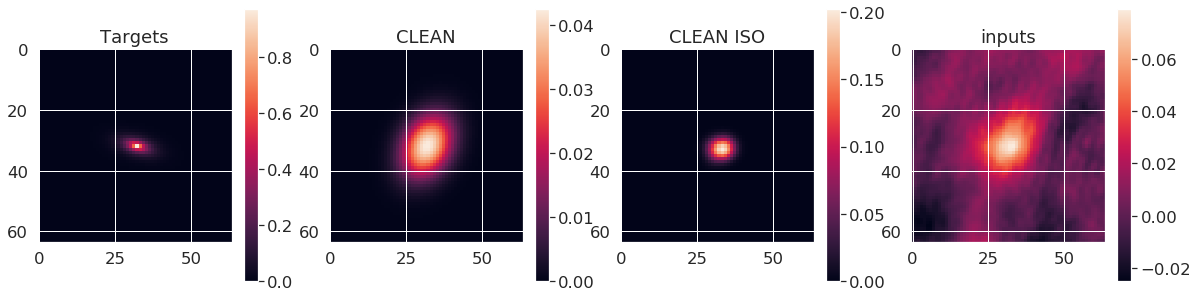

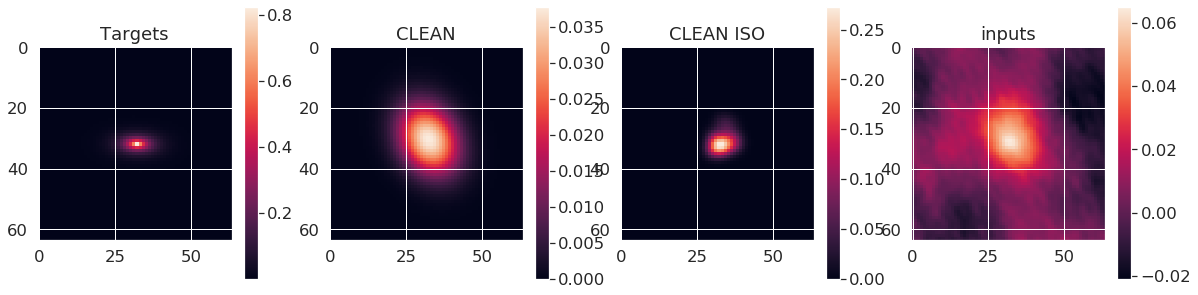

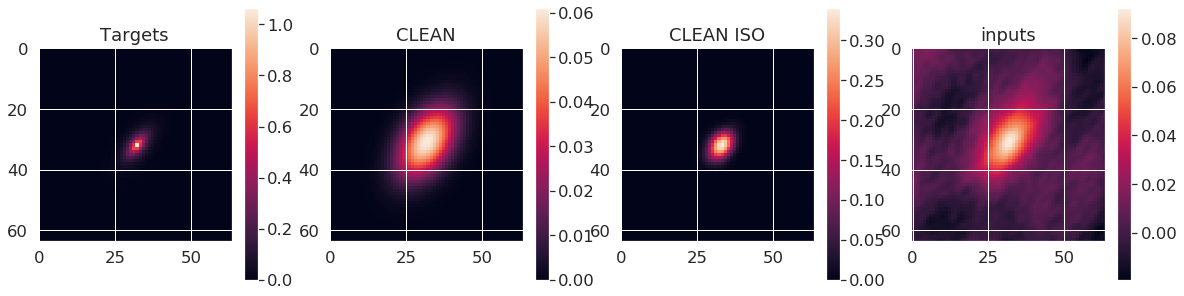

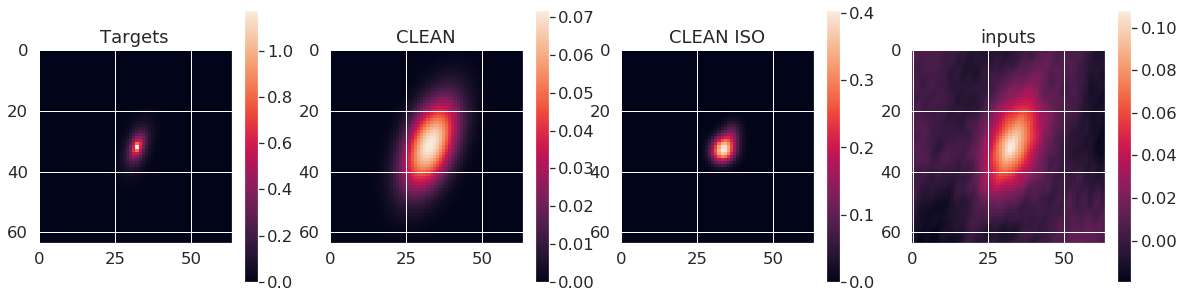

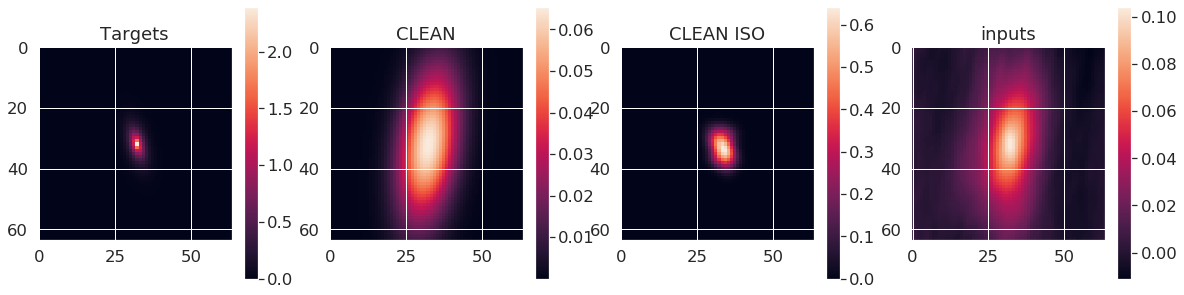

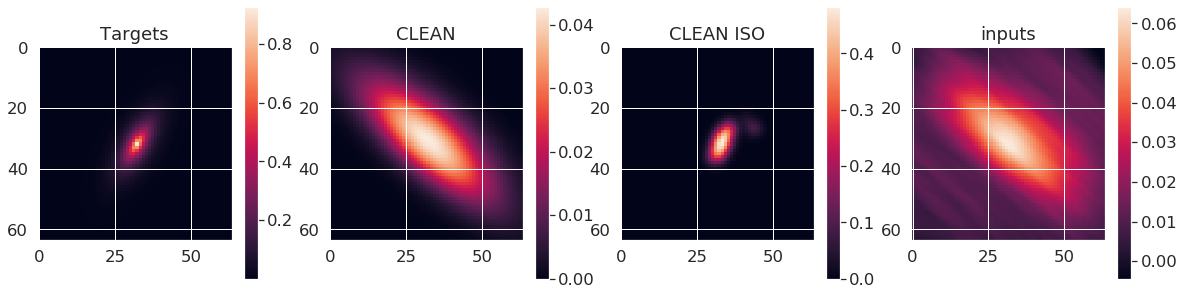

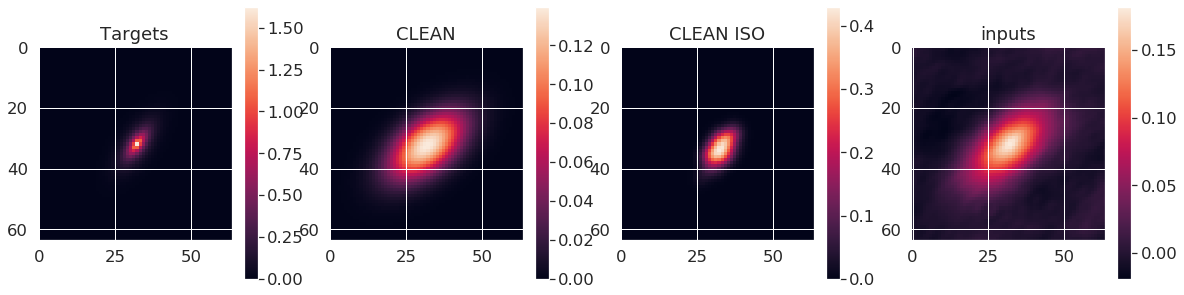

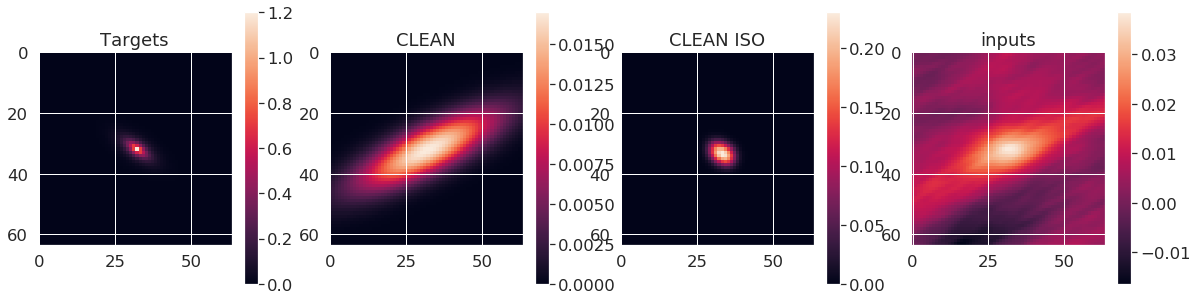

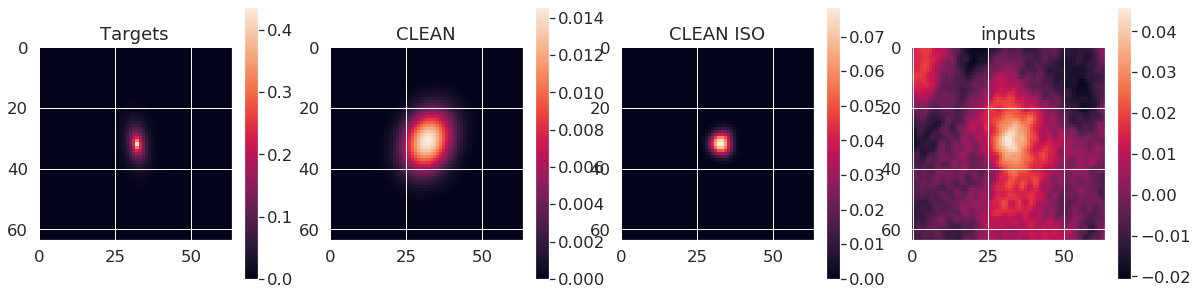

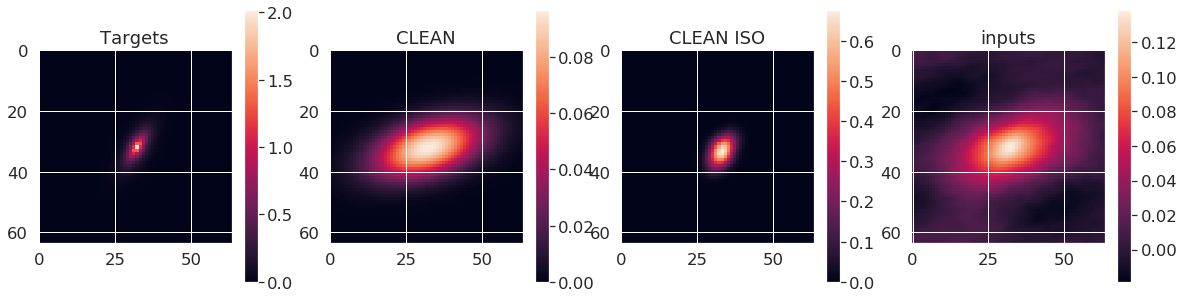

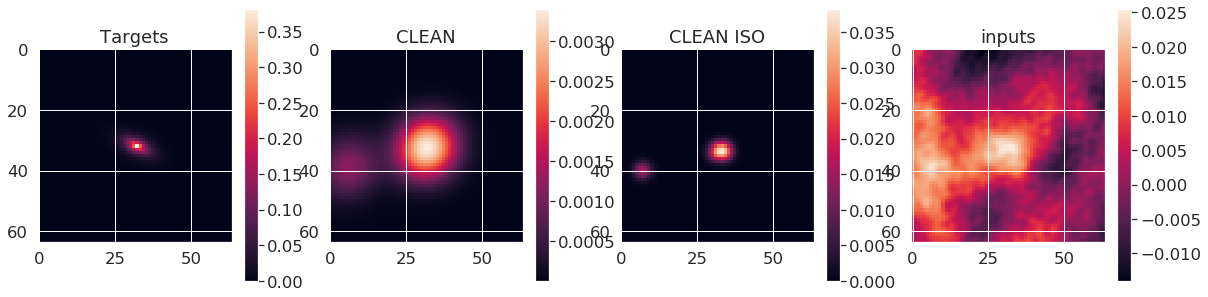

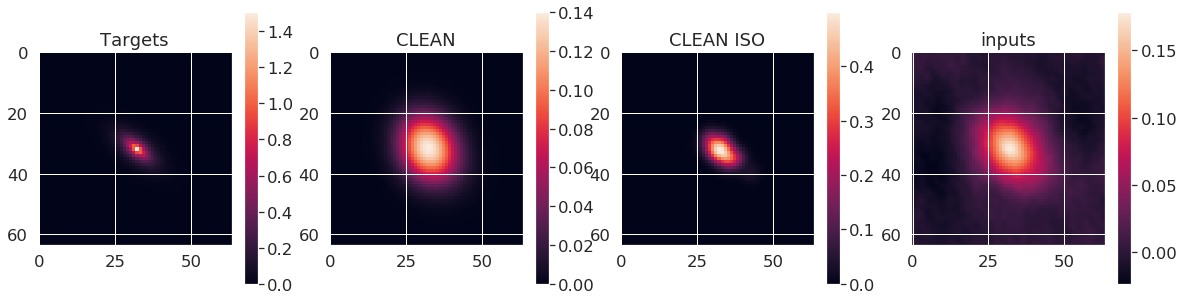

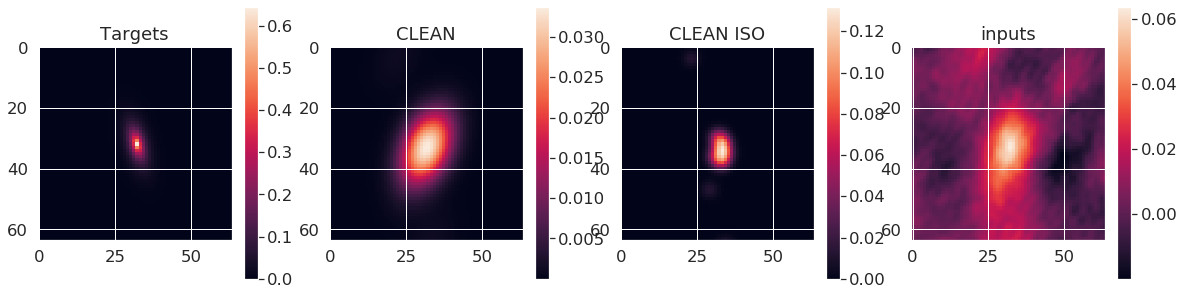

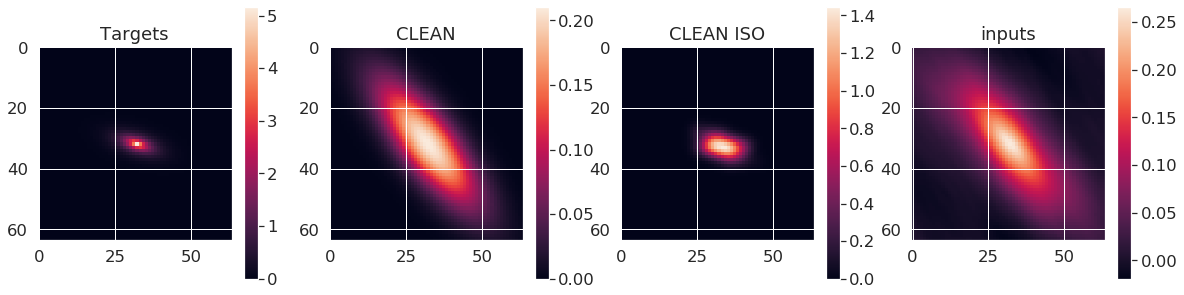

In [11]:
for i in range(20):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(res_cl[i])#res_g05[i])
    plt.title(r'CLEAN')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(res_cl_iso[i])#res_g0[i])
    plt.title(r'CLEAN ISO')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

In [12]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 1.5

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse
def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
        window_flag_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 1.2 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
            window_flag = bool(shape.moments_status+1)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_cl_iso*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
            window_flag_list += [window_flag]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0],np.array([window_flag_list])[0]]
    return output

In [13]:
# compute pixel errors
mse_g0 = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_g0)])
mse_g05 = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_g05)])
mse_cl_iso = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_cl_iso)])
mse_cl = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_cl)])
mse_s0 = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_s0)])
mse_s1 = np.array([MSE_obj(est,true) for true,est in zip(batch['targets'], res_s1)])

# compute relative pixel errors
mse_g0_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_g0)])
mse_g05_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_g05)])
mse_cl_iso_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_cl_iso)])
mse_cl_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_cl)])
mse_s0_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_s0)])
mse_s1_rel = np.array([relative_mse(est,true) for true,est in zip(batch['targets'], res_s1)])

# estimate moments
mom_g0,_ = get_moments(res_g0)
mom_g05,_ = get_moments(res_g05)
mom_cl_iso,_ = get_moments(res_cl_iso)
mom_cl,_ = get_moments(res_cl)
mom_s0,_ = get_moments(res_s0)
mom_s1,_ = get_moments(res_s1)
mom_true,_,windows, window_flags = get_moments(batch['targets'],bool_window=True)

# estimate flux
flux_g0 = np.array([gal.sum() for gal in res_g0]).T
flux_g05 = np.array([gal.sum() for gal in res_g05]).T
flux_cl_iso = np.array([gal.sum() for gal in res_cl_iso]).T
flux_cl = np.array([gal.sum() for gal in res_cl]).T
flux_s0 = np.array([gal.sum() for gal in res_s0]).T
flux_s1 = np.array([gal.sum() for gal in res_s1]).T
flux_true = np.array([gal.sum()  for gal in batch['targets']]).T

In [14]:
# compute adapative moments errors
mom_err_g0 = mom_g0-mom_true
mom_err_g05 = mom_g05-mom_true
mom_err_cl_iso = mom_cl_iso-mom_true
mom_err_cl = mom_cl-mom_true
mom_err_s0 = mom_s0-mom_true
mom_err_s1 = mom_s1-mom_true

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true
flux_err_cl = np.abs(flux_cl - flux_true) / flux_true
flux_err_cl_iso = np.abs(flux_cl_iso - flux_true) /flux_true
flux_err_s0 = np.abs(flux_s0 - flux_true) / flux_true
flux_err_s1 = np.abs(flux_s1 - flux_true) /flux_true

In [15]:
# MAKING SNR BINS
# Binning parameters
n_bins = 4
snr = np.array([np.max(gal) / cl.sigma_mad(gal) for gal in batch['inputs']])

# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(snr)
ind_list = []
bins = []
sqrt_num_gal = []

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(snr,(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=snr,snr<q)
    ind = np.arange(cond.size)[cond]
    sqrt_num_gal += [np.sqrt(cond.sum())]
    # retrieve corresponding objects
    snr_q = snr[ind]
    ind_list += [ind]
    print(i+1, q, np.mean(snr_q))
    bins += [np.mean(snr_q)]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=snr
ind = np.arange(cond.size)[cond]
# retrieve corresponding objects
snr_q = snr[ind]
ind_list += [ind]
sqrt_num_gal += [np.sqrt(cond.sum())]
bins += [np.mean(snr_q)]
print(i+2, q, np.mean(snr_q))

# END BINNING

1 5.757177702968617 4.378329972179469
2 8.294482686076222 6.919606640432914
3 12.207562119655655 9.9853122079986
4 12.207562119655655 16.738446122311043


In [16]:
# computing mean and standard deviation of relative mse error per binned SNR

mse_mean_g0 = []
mse_mean_g05 = []
mse_mean_cl_iso = []
mse_mean_cl = []
mse_mean_s0 = []
mse_mean_s1 = []

mse_std_g0 = []
mse_std_g05 = []
mse_std_cl_iso = []
mse_std_cl = []
mse_std_s0 = []
mse_std_s1 = []

mse_mean_g0_rel = []
mse_mean_g05_rel = []
mse_mean_cl_iso_rel = []
mse_mean_cl_rel = []
mse_mean_s0_rel = []
mse_mean_s1_rel = []

mse_std_g0_rel = []
mse_std_g05_rel = []
mse_std_cl_iso_rel = []
mse_std_cl_rel = []
mse_std_s0_rel = []
mse_std_s1_rel = []

# computing mean and standard deviation of adapative moments error per binned SNR

mom_mean_g0 = []
mom_mean_g05 = []
mom_mean_cl_iso = []
mom_mean_cl = []
mom_mean_s0 = []
mom_mean_s1 = []

mom_median_g0 = []
mom_median_g05 = []
mom_median_cl_iso = []
mom_median_cl = []
mom_median_s0 = []
mom_median_s1 = []

mom_std_g0 = []
mom_std_g05 = []
mom_std_cl_iso = []
mom_std_cl = []
mom_std_s0 = []
mom_std_s1 = []

# computing mean and standard deviation of relative flux error per binned SNR

flux_mean_g0 = []
flux_mean_g05 = []
flux_mean_cl_iso = []
flux_mean_cl = []
flux_mean_s0 = []
flux_mean_s1 = []

flux_std_g0 = []
flux_std_g05 = []
flux_std_cl_iso = []
flux_std_cl = []
flux_std_s0 = []
flux_std_s1 = []

for ind in ind_list:
    
    mse_mean_g0 += [np.mean(mse_g0[ind])]
    mse_mean_g05 += [np.mean(mse_g05[ind])]
    mse_mean_cl_iso += [np.mean(mse_cl_iso[ind])]
    mse_mean_cl += [np.mean(mse_cl[ind])]
    mse_mean_s0 += [np.mean(mse_s0[ind])]
    mse_mean_s1 += [np.mean(mse_s1[ind])]

    mse_std_g0 += [np.std(mse_g0[ind])]
    mse_std_g05 += [np.std(mse_g05[ind])]
    mse_std_cl_iso += [np.std(mse_cl_iso[ind])]
    mse_std_cl += [np.std(mse_cl[ind])]
    mse_std_s0 += [np.std(mse_s0[ind])]
    mse_std_s1 += [np.std(mse_s1[ind])]
    
    mse_mean_g0_rel += [np.mean(mse_g0_rel[ind])]
    mse_mean_g05_rel += [np.mean(mse_g05_rel[ind])]
    mse_mean_cl_iso_rel += [np.mean(mse_cl_iso_rel[ind])]
    mse_mean_cl_rel += [np.mean(mse_cl_rel[ind])]
    mse_mean_s0_rel += [np.mean(mse_s0_rel[ind])]
    mse_mean_s1_rel += [np.mean(mse_s1_rel[ind])]

    mse_std_g0_rel += [np.std(mse_g0_rel[ind])]
    mse_std_g05_rel += [np.std(mse_g05_rel[ind])]
    mse_std_cl_iso_rel += [np.std(mse_cl_iso_rel[ind])]
    mse_std_cl_rel += [np.std(mse_cl_rel[ind])]
    mse_std_s0_rel += [np.std(mse_s0_rel[ind])]
    mse_std_s1_rel += [np.std(mse_s1_rel[ind])]
    
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_mean_cl_iso += [np.mean(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_mean_cl += [np.mean(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_mean_s1 += [np.mean(np.abs(mom_err_s1[:,ind]),axis=1)]
    
    mom_median_g0 += [np.median(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_median_g05 += [np.median(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_median_cl_iso += [np.median(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_median_cl += [np.median(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_median_s0 += [np.median(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_median_s1 += [np.median(np.abs(mom_err_s1[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05[:,ind]),axis=1)]
    mom_std_cl_iso += [np.std(np.abs(mom_err_cl_iso[:,ind]),axis=1)]
    mom_std_cl += [np.std(np.abs(mom_err_cl[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0[:,ind]),axis=1)]
    mom_std_s1 += [np.std(np.abs(mom_err_s1[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(flux_err_g0[ind])]
    flux_mean_g05 += [np.mean(flux_err_g05[ind])]
    flux_mean_cl_iso += [np.mean(flux_err_cl_iso[ind])]
    flux_mean_cl += [np.mean(flux_err_cl[ind])]
    flux_mean_s0 += [np.mean(flux_err_s0[ind])]
    flux_mean_s1 += [np.mean(flux_err_s1[ind])]

    flux_std_g0 += [np.std(flux_err_g0[ind])]
    flux_std_g05 += [np.std(flux_err_g05[ind])]
    flux_std_cl_iso += [np.std(flux_err_cl_iso[ind])]
    flux_std_cl += [np.std(flux_err_cl[ind])]
    flux_std_s0 += [np.std(flux_err_s0[ind])]
    flux_std_s1 += [np.std(flux_err_s1[ind])]
    
# Convert to numpy array with shape (2, n_bins)

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g05 = np.array(mse_mean_g05).T
mse_mean_cl_iso = np.array(mse_mean_cl_iso).T
mse_mean_cl = np.array(mse_mean_cl).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_s1 = np.array(mse_mean_s1).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g05 = np.array(mse_std_g05).T
mse_std_cl_iso = np.array(mse_std_cl_iso).T
mse_std_cl = np.array(mse_std_cl).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_s1 = np.array(mse_std_s1).T

mse_mean_g0_rel = np.array(mse_mean_g0_rel).T
mse_mean_g05_rel = np.array(mse_mean_g05_rel).T
mse_mean_cl_iso_rel = np.array(mse_mean_cl_iso_rel).T
mse_mean_cl_rel = np.array(mse_mean_cl_rel).T
mse_mean_s0_rel = np.array(mse_mean_s0_rel).T
mse_mean_s1_rel = np.array(mse_mean_s1_rel).T

mse_std_g0_rel = np.array(mse_std_g0_rel).T
mse_std_g05_rel = np.array(mse_std_g05_rel).T
mse_std_cl_iso_rel = np.array(mse_std_cl_iso_rel).T
mse_std_cl_rel = np.array(mse_std_cl_rel).T
mse_std_s0_rel = np.array(mse_std_s0_rel).T
mse_std_s1_rel = np.array(mse_std_s1_rel).T

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g05 = np.array(mom_mean_g05).T
mom_mean_cl_iso = np.array(mom_mean_cl_iso).T
mom_mean_cl = np.array(mom_mean_cl).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_s1 = np.array(mom_mean_s1).T

mom_median_g0 = np.array(mom_median_g0).T
mom_median_g05 = np.array(mom_median_g05).T
mom_median_cl_iso = np.array(mom_median_cl_iso).T
mom_median_cl = np.array(mom_median_cl).T
mom_median_s0 = np.array(mom_median_s0).T
mom_median_s1 = np.array(mom_median_s1).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g05 = np.array(mom_std_g05).T
mom_std_cl_iso = np.array(mom_std_cl_iso).T
mom_std_cl = np.array(mom_std_cl).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_s1 = np.array(mom_std_s1).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_g05 = np.array(flux_mean_g05).T
flux_mean_cl_iso = np.array(flux_mean_cl_iso).T
flux_mean_cl = np.array(flux_mean_cl).T
flux_mean_s0 = np.array(flux_mean_s0).T
flux_mean_s1 = np.array(flux_mean_s1).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_g05 = np.array(flux_std_g05).T
flux_std_cl_iso = np.array(flux_std_cl_iso).T
flux_std_cl = np.array(flux_std_cl).T
flux_std_s0 = np.array(flux_std_s0).T
flux_std_s1 = np.array(flux_std_s1).T

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


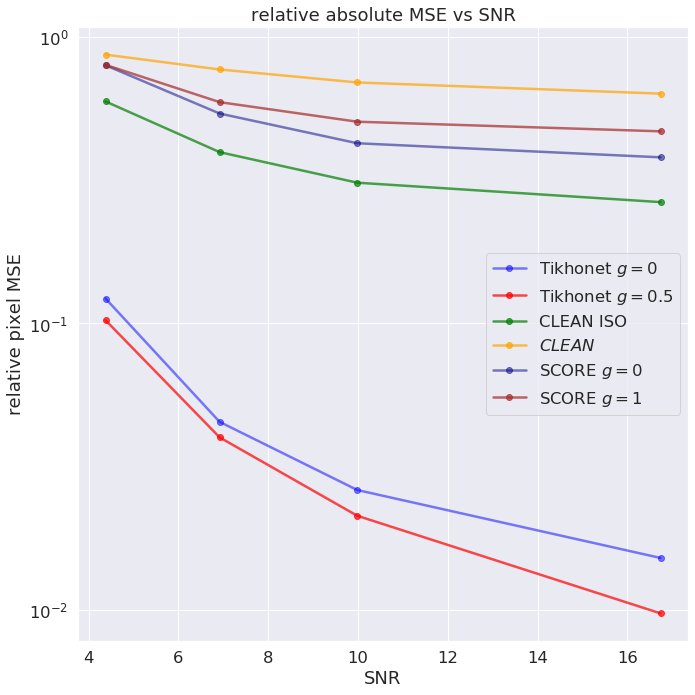

In [17]:
color_g0 = 'blue'
color_g05 = 'red'
color_cl_iso = 'green'
color_cl = 'orange'
color_s0 = 'navy'
color_s1 = 'brown'

label_g0 = r'Tikhonet $g=0$'
label_g05 = r'Tikhonet $g=0.5$'
label_cl_iso = r'CLEAN ISO'
label_cl = r'$CLEAN$'
label_s0 = r'SCORE $g=0$'
label_s1 = r'SCORE $g=1$'

# plt.figure(figsize=(10,10))
# # plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# # plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# # plt.errorbar(bins,mse_mean_cl_iso,mse_std_cl_iso/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# # plt.errorbar(bins,mse_mean_cl,mse_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.ylim(bottom=0)
# #plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.xlabel(r'SNR')
# plt.ylabel(r'pixel MSE')
# plt.title(r'absolute MSE vs SNR')
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_iso_rel,mse_std_cl_iso_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_rel,mse_std_cl_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.semilogy(bins,mse_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_cl_iso_rel,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.semilogy(bins,mse_mean_cl_rel,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.semilogy(bins,mse_mean_s0_rel,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1_rel,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'relative pixel MSE')
plt.title(r'relative absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

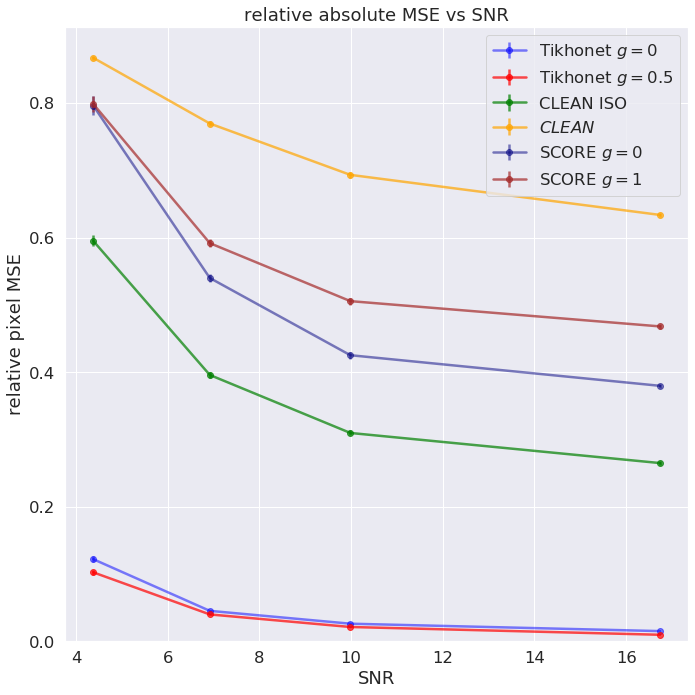

In [18]:
# plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl_iso,mse_std_cl_iso/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.errorbar(bins,mse_mean_cl,mse_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# # plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# # plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# # plt.semilogy(bins,mse_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# # plt.semilogy(bins,mse_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
# plt.ylim(bottom=0)
# #plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.xlabel(r'SNR')
# plt.ylabel(r'pixel MSE')
# plt.title(r'absolute MSE vs SNR')
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mse_mean_cl_iso_rel,mse_std_cl_iso_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mse_mean_cl_rel,mse_std_cl_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mse_mean_s0_rel,mse_std_s0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_s1_rel,mse_std_s1_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_iso_rel,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
# plt.semilogy(bins,mse_mean_cl_rel,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'relative pixel MSE')
plt.title(r'relative absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

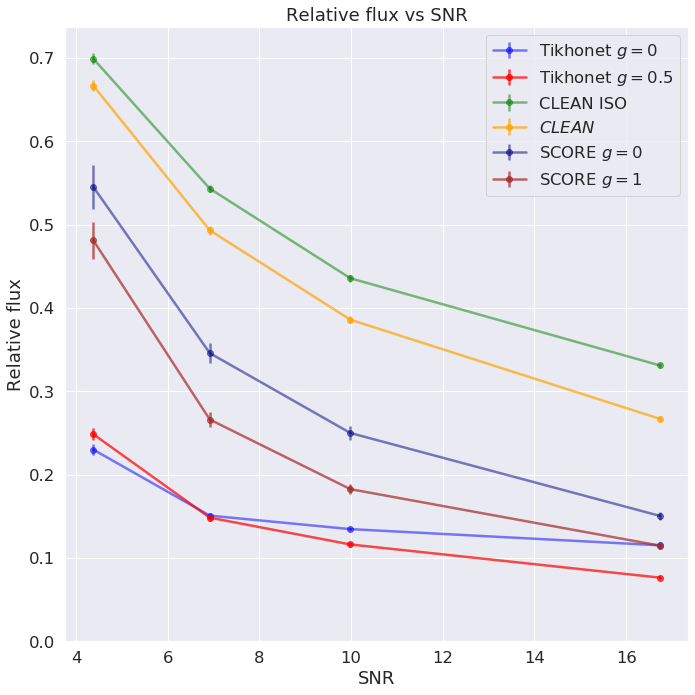

In [19]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,flux_mean_cl_iso,flux_std_cl/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.5)
plt.errorbar(bins,flux_mean_cl,flux_std_cl_iso/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,flux_mean_s0,flux_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,flux_mean_s1,flux_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.semilogy(bins,flux_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,flux_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,flux_mean_cl_iso,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.5)
# plt.semilogy(bins,flux_mean_cl,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'Relative flux')
plt.title(r'Relative flux vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

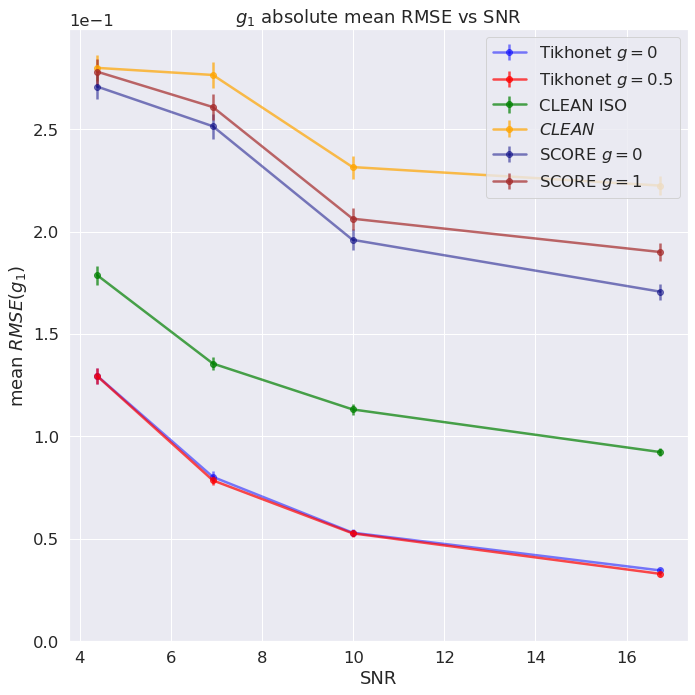

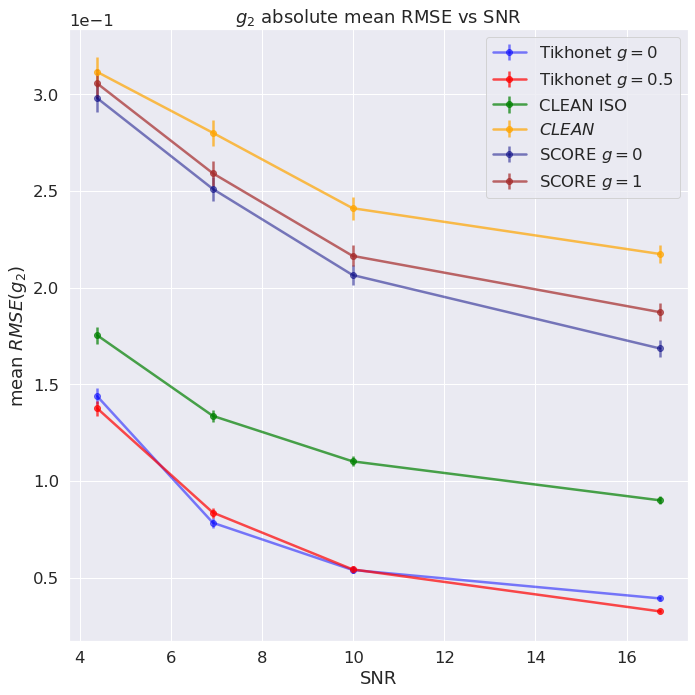

In [20]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_cl_iso[0],mom_std_cl_iso[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_mean_cl[0],mom_std_cl[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(g_{1})$')
plt.title(r'$g_1$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_mean_cl_iso[1],mom_std_cl_iso[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_mean_cl[1],mom_std_cl[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(g_2)$')
plt.title(r'$g_2$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

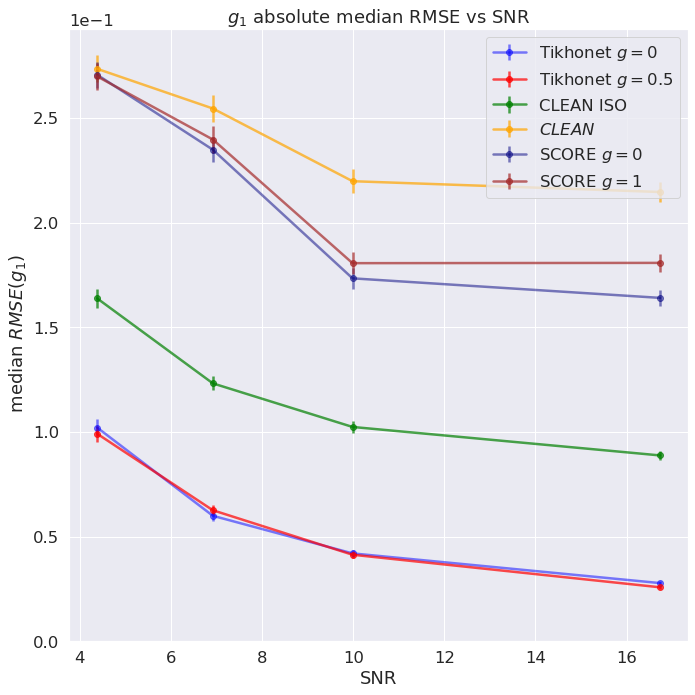

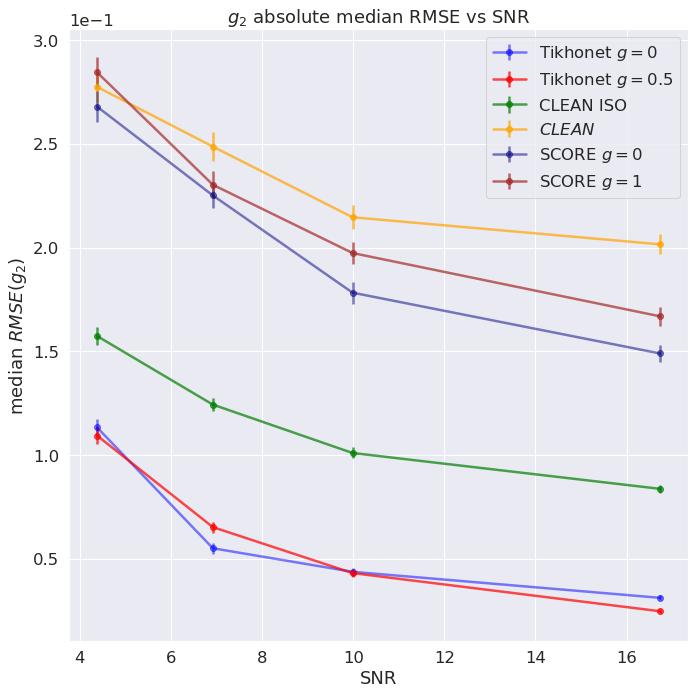

In [21]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_median_cl_iso[0],mom_std_cl_iso[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_median_cl[0],mom_std_cl[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_median_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_median_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r' median $RMSE(g_{1})$')
plt.title(r'$g_1$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.errorbar(bins,mom_median_cl_iso[1],mom_std_cl_iso[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl_iso,label=label_cl_iso,alpha=0.7)
plt.errorbar(bins,mom_median_cl[1],mom_std_cl[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_cl,label=label_cl,alpha=0.7)
plt.errorbar(bins,mom_median_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_median_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'median $RMSE(g_2)$')
plt.title(r'$g_2$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

## Investigate CLEAN MSE at low SNR

(array([  5.,  21.,  52., 162., 397., 735., 697., 610., 261.,  60.]),
 array([0.21221206, 0.2980951 , 0.38397814, 0.46986119, 0.55574423,
        0.64162727, 0.72751032, 0.81339336, 0.8992764 , 0.98515944,
        1.07104249]),
 <a list of 10 Patch objects>)

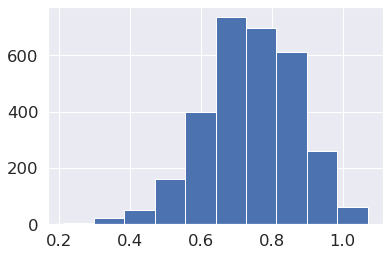

In [22]:
plt.hist(mse_cl_rel)

In [23]:
(mse_cl_rel>1000).sum()

0